In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

1 Physical GPUs, 1 Logical GPUs


## Non-Cyclic Stocks

### Kweichow Moutai Co., Ltd.

In [4]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


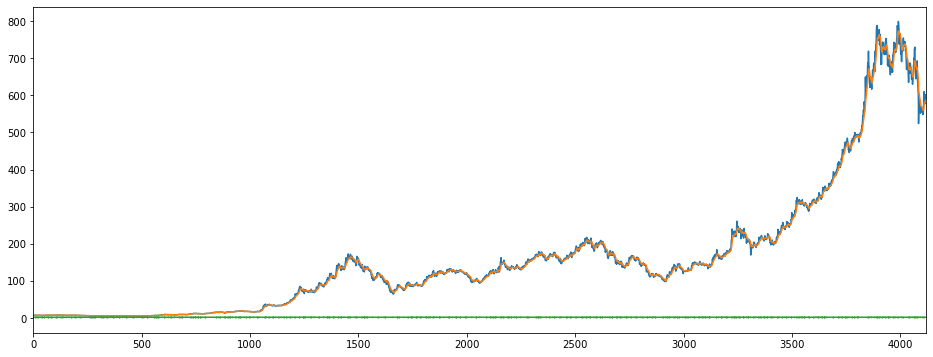

In [5]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [6]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2001-09-14,7.142585,7.257483,-41.873824,204624213.0,2.0
2001-09-17,7.224180,7.252359,-51.296847,208479649.0,2.0
2001-09-18,7.132634,7.233940,-72.964156,203965392.0,2.0
2001-09-19,7.214230,7.230908,-59.609037,209378730.0,2.0
2001-09-20,7.347568,7.248855,-37.785092,213725440.0,2.0


In [7]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)
X.shape

(4106, 64, 64, 1)

In [8]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [9]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [10]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [12]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.396396396396397, 1: 7.497716894977169, 2: 0.3661092530657748}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.3111 - accuracy: 0.6484 - mse: 0.4223 - weighted_accuracy: 0.2914 - weighted_mse: 0.5055WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 25ms/step - loss: 0.2222 - accuracy: 0.3608 - mse: 0.9236 - weighted_accuracy: 0.2989 - weighted_mse: 0.9553 - val_loss: 0.1890 - val_accuracy: 0.2299 - val_mse: 1.1472 - val_weighted_accuracy: 0.2299 - val_weighted_mse: 1.1472
Epoch 2/200
26/26 [==============================] - 0s 10ms/step - loss: 0.2033 - accuracy: 0.3971 - mse: 1.1622 - weighted_accuracy: 0.3503 - weighted_mse: 1.1791 - val_loss: 0.1865 - val_accuracy: 0.5839 - va

Epoch 27/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1699 - accuracy: 0.2244 - mse: 1.4529 - weighted_accuracy: 0.5696 - weighted_mse: 1.3574 - val_loss: 0.2020 - val_accuracy: 0.1582 - val_mse: 1.3470 - val_weighted_accuracy: 0.1582 - val_weighted_mse: 1.3470
Epoch 28/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1676 - accuracy: 0.1778 - mse: 1.4675 - weighted_accuracy: 0.5850 - weighted_mse: 1.3480 - val_loss: 0.2057 - val_accuracy: 0.1302 - val_mse: 1.4017 - val_weighted_accuracy: 0.1302 - val_weighted_mse: 1.4017
Epoch 29/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1692 - accuracy: 0.2065 - mse: 1.4596 - weighted_accuracy: 0.5568 - weighted_mse: 1.3459 - val_loss: 0.2010 - val_accuracy: 0.1642 - val_mse: 1.4233 - val_weighted_accuracy: 0.1642 - val_weighted_mse: 1.4233
Epoch 30/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1645 - accuracy: 0.2396 - mse: 1.4710 - weighted_accuracy: 0.5970 - w

Epoch 56/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1550 - accuracy: 0.2403 - mse: 1.6771 - weighted_accuracy: 0.6358 - weighted_mse: 1.5706 - val_loss: 0.2024 - val_accuracy: 0.2032 - val_mse: 1.4976 - val_weighted_accuracy: 0.2032 - val_weighted_mse: 1.4976
Epoch 57/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1558 - accuracy: 0.2421 - mse: 1.6400 - weighted_accuracy: 0.6279 - weighted_mse: 1.5190 - val_loss: 0.2031 - val_accuracy: 0.1764 - val_mse: 1.5609 - val_weighted_accuracy: 0.1764 - val_weighted_mse: 1.5609
Epoch 58/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1534 - accuracy: 0.2530 - mse: 1.6581 - weighted_accuracy: 0.6339 - weighted_mse: 1.5626 - val_loss: 0.2028 - val_accuracy: 0.1983 - val_mse: 1.5982 - val_weighted_accuracy: 0.1983 - val_weighted_mse: 1.5982
Epoch 59/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1548 - accuracy: 0.2865 - mse: 1.6824 - weighted_accuracy: 0.6224 - 

Epoch 85/200
26/26 [==============================] - 0s 14ms/step - loss: 0.1465 - accuracy: 0.2710 - mse: 1.8586 - weighted_accuracy: 0.6599 - weighted_mse: 1.7394 - val_loss: 0.1995 - val_accuracy: 0.2543 - val_mse: 1.7073 - val_weighted_accuracy: 0.2543 - val_weighted_mse: 1.7073
Epoch 86/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1467 - accuracy: 0.3225 - mse: 1.8202 - weighted_accuracy: 0.6637 - weighted_mse: 1.7071 - val_loss: 0.2012 - val_accuracy: 0.2457 - val_mse: 1.7803 - val_weighted_accuracy: 0.2457 - val_weighted_mse: 1.7803
Epoch 87/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1476 - accuracy: 0.2756 - mse: 1.8351 - weighted_accuracy: 0.6596 - weighted_mse: 1.7186 - val_loss: 0.1977 - val_accuracy: 0.2433 - val_mse: 1.7077 - val_weighted_accuracy: 0.2433 - val_weighted_mse: 1.7077
Epoch 88/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1444 - accuracy: 0.3234 - mse: 1.7972 - weighted_accuracy: 0.6812 - 

Epoch 114/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1409 - accuracy: 0.3234 - mse: 2.0298 - weighted_accuracy: 0.6705 - weighted_mse: 1.9718 - val_loss: 0.1995 - val_accuracy: 0.2506 - val_mse: 1.8474 - val_weighted_accuracy: 0.2506 - val_weighted_mse: 1.8474
Epoch 115/200
26/26 [==============================] - 0s 14ms/step - loss: 0.1380 - accuracy: 0.3566 - mse: 1.9248 - weighted_accuracy: 0.7020 - weighted_mse: 1.8671 - val_loss: 0.1969 - val_accuracy: 0.2798 - val_mse: 1.9045 - val_weighted_accuracy: 0.2798 - val_weighted_mse: 1.9045
Epoch 116/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1387 - accuracy: 0.3179 - mse: 2.0143 - weighted_accuracy: 0.6987 - weighted_mse: 1.9298 - val_loss: 0.1933 - val_accuracy: 0.3029 - val_mse: 1.8845 - val_weighted_accuracy: 0.3029 - val_weighted_mse: 1.8845
Epoch 117/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1383 - accuracy: 0.3526 - mse: 1.9625 - weighted_accuracy: 0.694

Epoch 143/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1303 - accuracy: 0.4035 - mse: 2.2064 - weighted_accuracy: 0.7256 - weighted_mse: 2.1509 - val_loss: 0.2007 - val_accuracy: 0.2956 - val_mse: 2.0958 - val_weighted_accuracy: 0.2956 - val_weighted_mse: 2.0958
Epoch 144/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1316 - accuracy: 0.3803 - mse: 2.2292 - weighted_accuracy: 0.7258 - weighted_mse: 2.1897 - val_loss: 0.2044 - val_accuracy: 0.2737 - val_mse: 2.1142 - val_weighted_accuracy: 0.2737 - val_weighted_mse: 2.1142
Epoch 145/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1299 - accuracy: 0.4062 - mse: 2.1773 - weighted_accuracy: 0.7353 - weighted_mse: 2.2198 - val_loss: 0.1889 - val_accuracy: 0.3418 - val_mse: 2.0745 - val_weighted_accuracy: 0.3418 - val_weighted_mse: 2.0745
Epoch 146/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1306 - accuracy: 0.4272 - mse: 2.2100 - weighted_accuracy: 0.725

Epoch 172/200
26/26 [==============================] - 0s 14ms/step - loss: 0.1215 - accuracy: 0.4708 - mse: 2.4265 - weighted_accuracy: 0.7631 - weighted_mse: 2.4835 - val_loss: 0.1863 - val_accuracy: 0.4027 - val_mse: 2.3759 - val_weighted_accuracy: 0.4027 - val_weighted_mse: 2.3759
Epoch 173/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1211 - accuracy: 0.4677 - mse: 2.4814 - weighted_accuracy: 0.7579 - weighted_mse: 2.6069 - val_loss: 0.1903 - val_accuracy: 0.3881 - val_mse: 2.2975 - val_weighted_accuracy: 0.3881 - val_weighted_mse: 2.2975
Epoch 174/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1227 - accuracy: 0.4708 - mse: 2.3802 - weighted_accuracy: 0.7675 - weighted_mse: 2.3947 - val_loss: 0.1881 - val_accuracy: 0.4063 - val_mse: 2.2465 - val_weighted_accuracy: 0.4063 - val_weighted_mse: 2.2465
Epoch 175/200
26/26 [==============================] - 0s 15ms/step - loss: 0.1187 - accuracy: 0.4802 - mse: 2.4321 - weighted_accuracy: 0.788

In [13]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1895659863948822
Test accuracy: 0.43673965334892273


In [14]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.70167774 -1.2869755  -0.653753  ]
 [-2.362385    0.03462702 -0.6779547 ]
 [-1.1312125  -1.0882647  -0.17278005]
 ...
 [-0.6799558  -1.8305575  -0.21072656]
 [-0.66708726 -1.833537   -0.15254913]
 [-1.4423243  -0.79066926 -0.476465  ]]


Counter({2: 333, 1: 276, 0: 213})

In [15]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [16]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 822
actual predicted buys: 23
actual buys but predicted sell: 0
actual buys but predicted hold: 14
actual sells but predicted buy: 4
actual predicted sells: 25
actual sells but predicted hold: 8
actual holds but predicted buy: 249
actual holds but predicted sell: 188
actual predicted holds: 311
Percentage buys correct: 62.16216216216216%
Percentage sells correct: 67.56756756756756%
Percentage holds correct: 41.57754010695187%
actual buys: 37
actual sells: 37
actual holds: 748


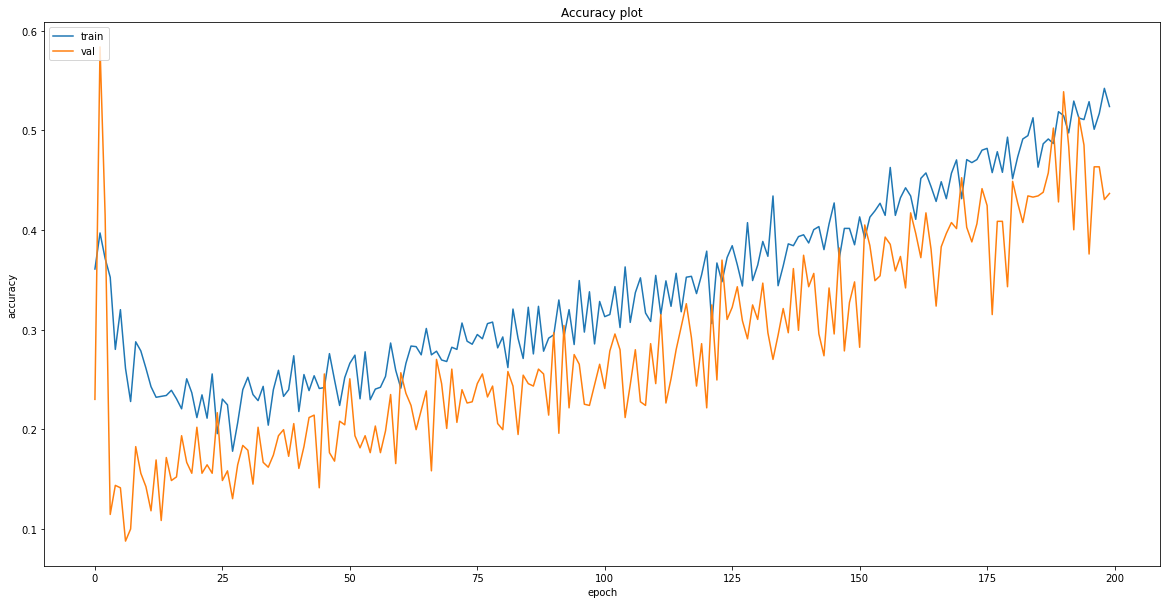

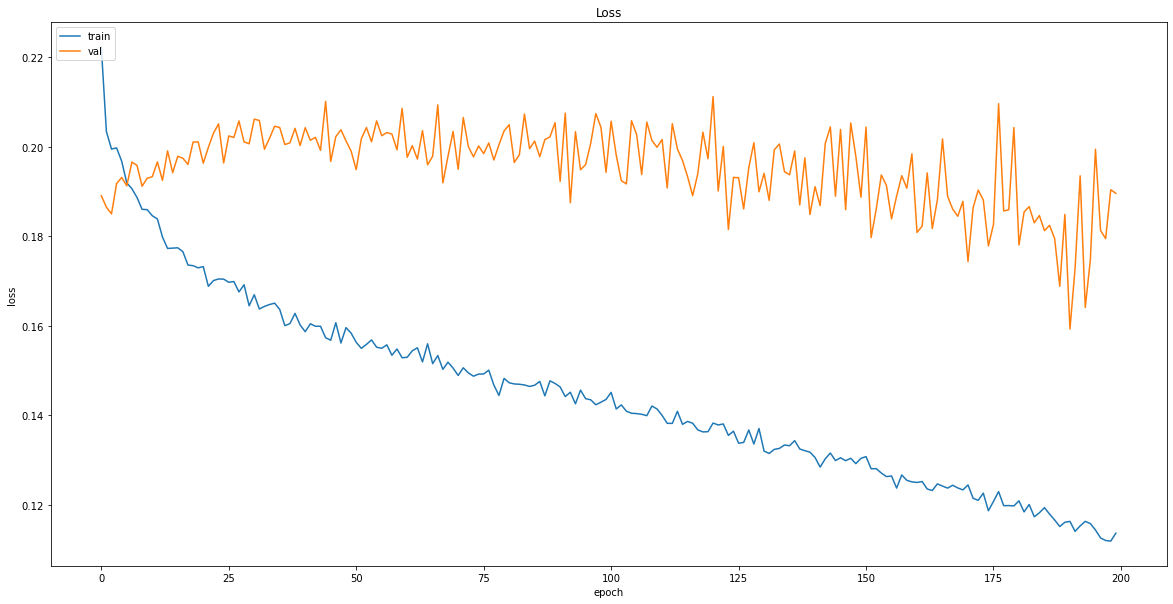

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
# Save model
model.save("models/{}".format('Moutai_time_series_cnn_buy_hold_sell_original.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Moutai_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [19]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


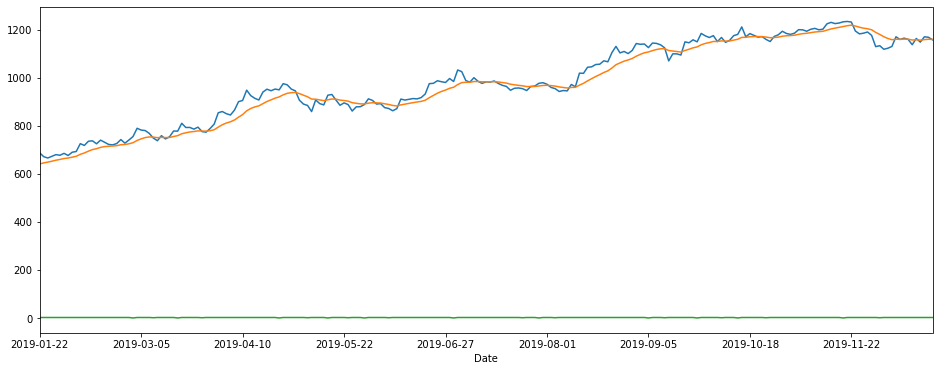

In [20]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [21]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [22]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [212]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [23]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [24]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [25]:
model = tf.keras.models.load_model("models/Moutai_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1842 - accuracy: 0.4203 - mean_squared_error: 2.7342 - weighted_accuracy: 0.4203 - weighted_mean_squared_error: 2.7342
Test loss: 0.18424491584300995
Test accuracy: 0.4202898442745209


In [26]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 87, 0: 63, 1: 57})

In [27]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [28]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [29]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,0,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,1,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,1,2


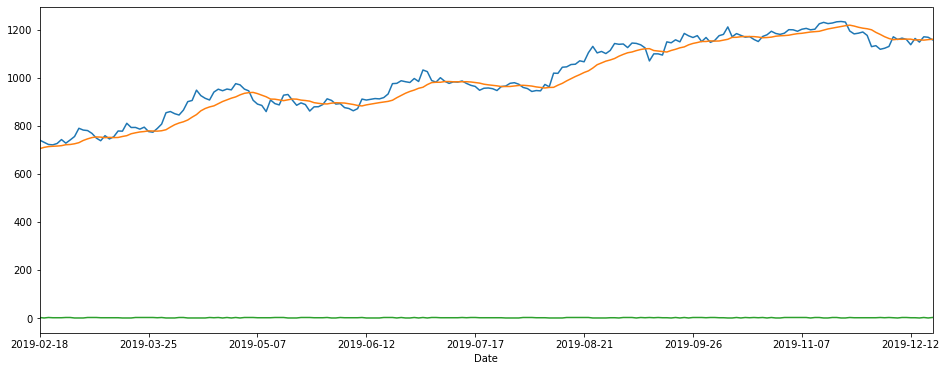

In [30]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

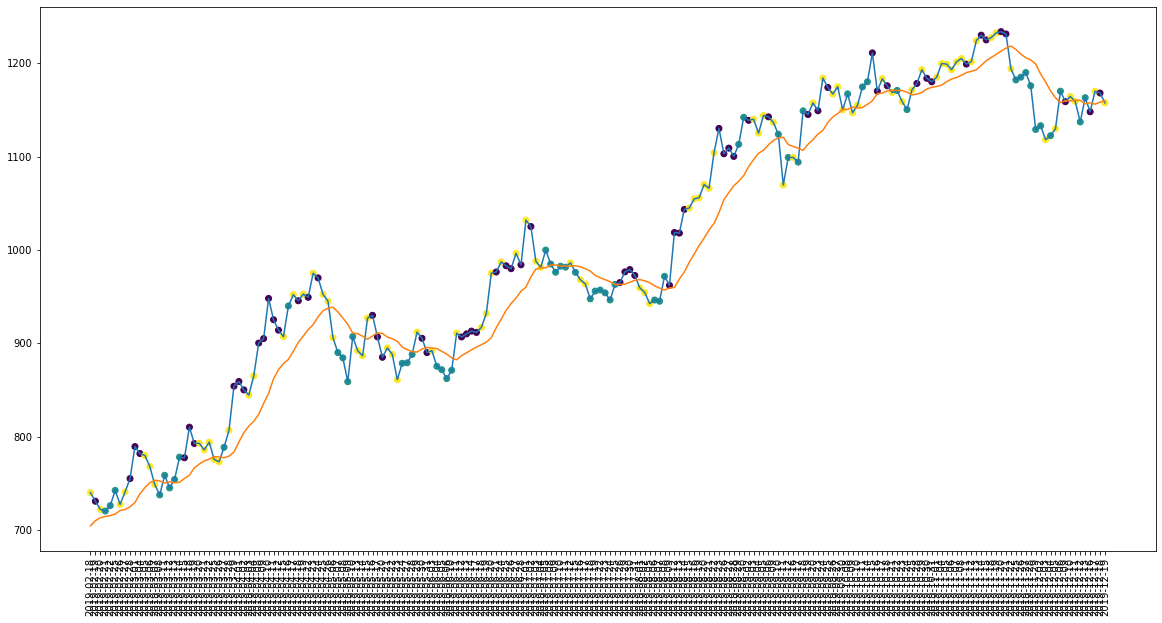

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

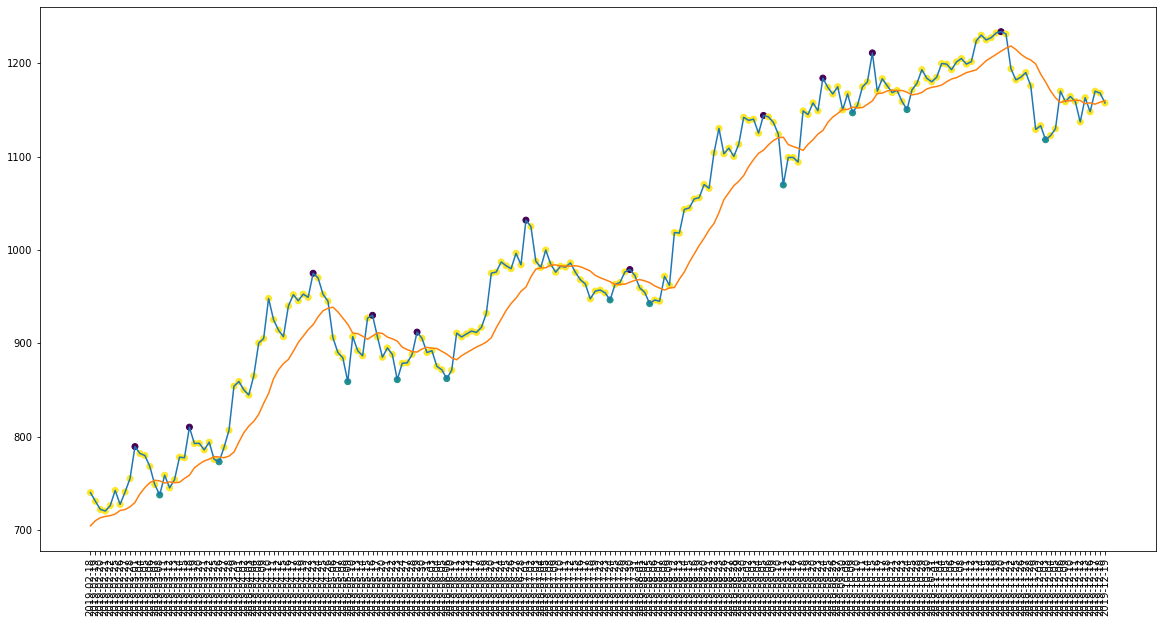

In [32]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [33]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 52
actual holds but predicted sell: 57
actual predicted holds: 76
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 41.08108108108108%
actual buys: 11
actual sells: 11
actual holds: 185


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 56.14035087719298%
Percentage sells correct: 46.03174603174603%
Percentage holds correct: 84.88372093023256%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $720.25
Shares owned at the moment: 13
Cash capital at the moment: $611.0010624999995


Price increase from previously bought: 9.286409654667116%
Share price: $789.2999877929688
Shares owned at the moment: 0
Cash capital at the moment: $10843.683429244995


Share price: $737.5
Shares owned at the moment: 14
Cash capital at the moment: $490.28967924499375


Price increase from previously bought: 5.10756271682955%
Share price: $777.2999877929688
Shares owned at the moment: 0
Cash capital at the moment: $11342.563458816527


Share price: $788.5
Shares owned at the moment: 14
Cash capital at the moment: $273.20620881652576


Price increase from previously bought: 8.008618687243562%
Share price: $853.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $12196.187457473752


Share price: $939.9000244140624
Shares owned at the moment: 12
Cash capital at the moment: $886.3704636993389


Stop Loss Activated!

Share price: $906.0
Shares owned at the moment: 0
Cash 

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [37]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


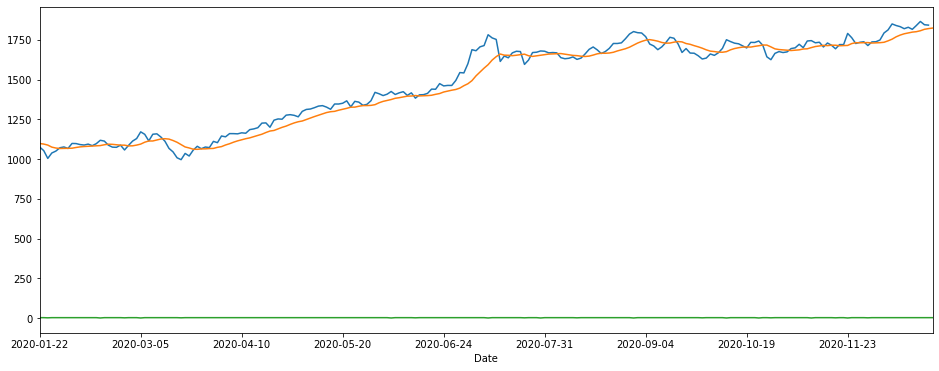

In [38]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [39]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [40]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [41]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [42]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [43]:
model = tf.keras.models.load_model("models/Moutai_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1886 - accuracy: 0.4279 - mean_squared_error: 2.6065 - weighted_accuracy: 0.4279 - weighted_mean_squared_error: 2.6065
Test loss: 0.18863961100578308
Test accuracy: 0.42788460850715637


In [44]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 78, 0: 88, 1: 42})

In [45]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [46]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [47]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,0,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


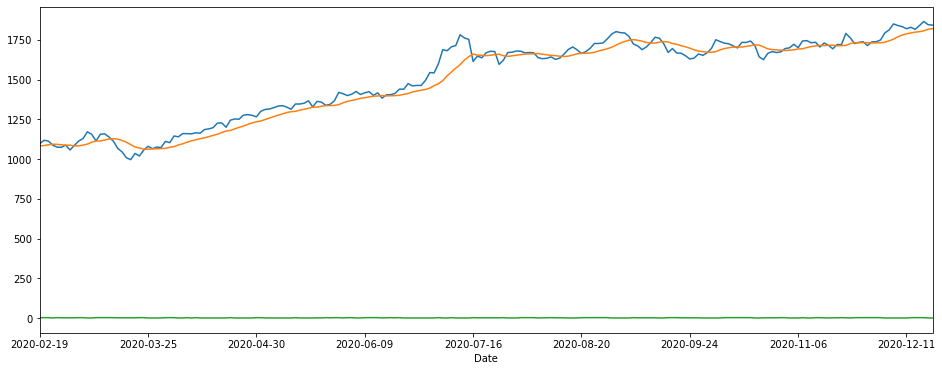

In [48]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

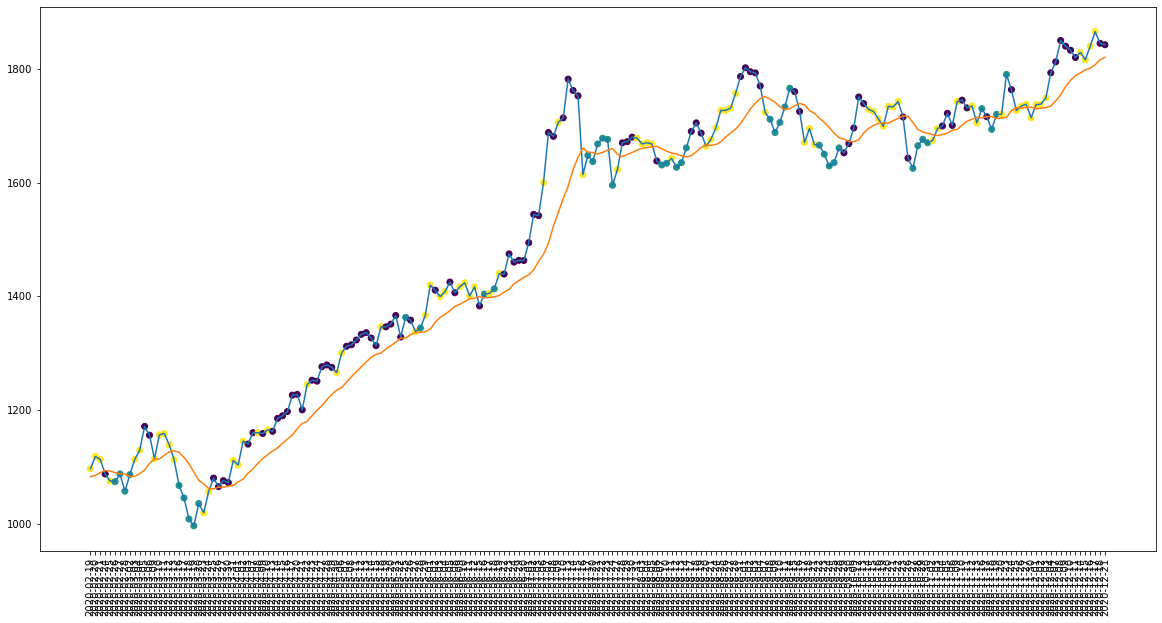

In [49]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

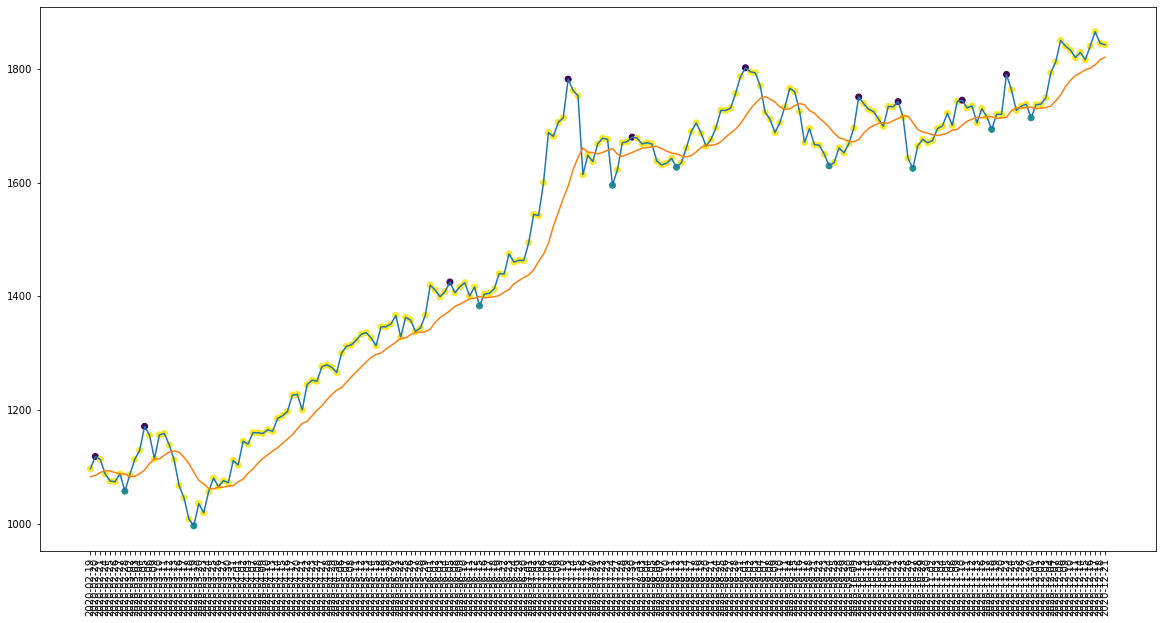

In [50]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [51]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 34
actual holds but predicted sell: 80
actual predicted holds: 75
Percentage buys correct: 77.77777777777777%
Percentage sells correct: 70.0%
Percentage holds correct: 39.682539682539684%
actual buys: 9
actual sells: 10
actual holds: 189


In [52]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 61.904761904761905%
Percentage sells correct: 51.13636363636363%
Percentage holds correct: 90.9090909090909%


In [53]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1073.699951171875
Shares owned at the moment: 9
Cash capital at the moment: $310.1263656616211


Price increase from previously bought: 8.763028267495043%
Share price: $1171.0
Shares owned at the moment: 0
Cash capital at the moment: $10820.14411566162


Share price: $1067.0
Shares owned at the moment: 10
Cash capital at the moment: $120.80161566161951


Stop Loss Activated!

Share price: $1007.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $10172.981793273924


Share price: $1007.989990234375
Shares owned at the moment: 10
Cash capital at the moment: $65.36216619872903


Price increase from previously bought: 6.859974498118526%
Share price: $1080.0999755859377
Shares owned at the moment: 0
Cash capital at the moment: $10836.659172729493


Share price: $1362.9000244140625
Shares owned at the moment: 7
Cash capital at the moment: $1270.123176361085


Price increase from previously bought: 5.294121130405527%
Share price: $1439.0
Shares owned at the m

In [54]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [55]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


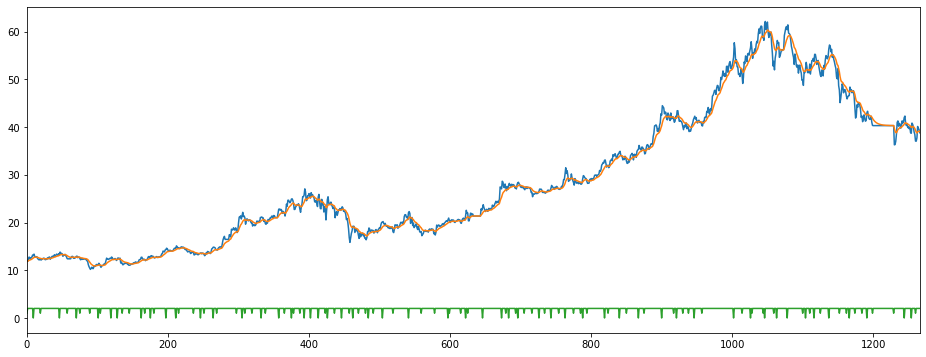

In [56]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [57]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [58]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [59]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [60]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [61]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [62]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [63]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [65]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.9523809523809526, 1: 6.816326530612245, 2: 0.36663007683863885}
Epoch 1/200
8/8 [==============================] - 2s 273ms/step - loss: 0.2481 - accuracy: 0.5828 - mse: 0.5406 - weighted_accuracy: 0.2652 - weighted_mse: 0.5974 - val_loss: 0.2026 - val_accuracy: 0.3068 - val_mse: 0.6756 - val_weighted_accuracy: 0.3068 - val_weighted_mse: 0.6756
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2127 - accuracy: 0.3982 - mse: 0.9090 - weighted_accuracy: 0.3221 - weighted_mse: 0.9324 - val_loss: 0.1908 - val_accuracy: 0.0717 - val_mse: 1.0339 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.0339
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2109 - accuracy: 0.3503 - mse: 1.2252 - weighted_accuracy: 0.2723 - weighted_mse: 1.2359 - val_loss: 0.1900 - val_accuracy: 0.1076 - val_mse: 1.1969 - val_weighted_accuracy: 0.1076 - val_weighted_mse: 1.1969
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2050 - ac

Epoch 29/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1823 - accuracy: 0.2764 - mse: 1.2935 - weighted_accuracy: 0.5310 - weighted_mse: 1.2766 - val_loss: 0.1935 - val_accuracy: 0.1912 - val_mse: 1.1768 - val_weighted_accuracy: 0.1912 - val_weighted_mse: 1.1768
Epoch 30/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1811 - accuracy: 0.2605 - mse: 1.2371 - weighted_accuracy: 0.5543 - weighted_mse: 1.1810 - val_loss: 0.1943 - val_accuracy: 0.1793 - val_mse: 1.1343 - val_weighted_accuracy: 0.1793 - val_weighted_mse: 1.1343
Epoch 31/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1740 - accuracy: 0.2745 - mse: 1.2605 - weighted_accuracy: 0.5542 - weighted_mse: 1.1873 - val_loss: 0.1911 - val_accuracy: 0.1912 - val_mse: 1.2357 - val_weighted_accuracy: 0.1912 - val_weighted_mse: 1.2357
Epoch 32/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1761 - accuracy: 0.2615 - mse: 1.3331 - weighted_accuracy: 0.5664 - weighted

Epoch 58/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1636 - accuracy: 0.3204 - mse: 1.4391 - weighted_accuracy: 0.5850 - weighted_mse: 1.3101 - val_loss: 0.1898 - val_accuracy: 0.3068 - val_mse: 1.3443 - val_weighted_accuracy: 0.3068 - val_weighted_mse: 1.3443
Epoch 59/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1609 - accuracy: 0.2944 - mse: 1.5148 - weighted_accuracy: 0.6205 - weighted_mse: 1.4293 - val_loss: 0.1912 - val_accuracy: 0.3028 - val_mse: 1.3292 - val_weighted_accuracy: 0.3028 - val_weighted_mse: 1.3292
Epoch 60/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1621 - accuracy: 0.2924 - mse: 1.4437 - weighted_accuracy: 0.6092 - weighted_mse: 1.3602 - val_loss: 0.1890 - val_accuracy: 0.3386 - val_mse: 1.2629 - val_weighted_accuracy: 0.3386 - val_weighted_mse: 1.2629
Epoch 61/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1589 - accuracy: 0.3184 - mse: 1.4212 - weighted_accuracy: 0.6293 - weighted

Epoch 87/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1502 - accuracy: 0.3872 - mse: 1.6221 - weighted_accuracy: 0.6599 - weighted_mse: 1.5801 - val_loss: 0.1821 - val_accuracy: 0.4024 - val_mse: 1.3776 - val_weighted_accuracy: 0.4024 - val_weighted_mse: 1.3776
Epoch 88/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1459 - accuracy: 0.3852 - mse: 1.5114 - weighted_accuracy: 0.6864 - weighted_mse: 1.4958 - val_loss: 0.1846 - val_accuracy: 0.3984 - val_mse: 1.3268 - val_weighted_accuracy: 0.3984 - val_weighted_mse: 1.3268
Epoch 89/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1549 - accuracy: 0.3792 - mse: 1.5292 - weighted_accuracy: 0.6380 - weighted_mse: 1.4648 - val_loss: 0.1805 - val_accuracy: 0.4064 - val_mse: 1.3701 - val_weighted_accuracy: 0.4064 - val_weighted_mse: 1.3701
Epoch 90/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1495 - accuracy: 0.3902 - mse: 1.5426 - weighted_accuracy: 0.6538 - weighted

Epoch 116/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1447 - accuracy: 0.3523 - mse: 1.6612 - weighted_accuracy: 0.6675 - weighted_mse: 1.6170 - val_loss: 0.1955 - val_accuracy: 0.3307 - val_mse: 1.4560 - val_weighted_accuracy: 0.3307 - val_weighted_mse: 1.4560
Epoch 117/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1403 - accuracy: 0.3693 - mse: 1.6102 - weighted_accuracy: 0.6794 - weighted_mse: 1.5826 - val_loss: 0.1887 - val_accuracy: 0.3785 - val_mse: 1.4867 - val_weighted_accuracy: 0.3785 - val_weighted_mse: 1.4867
Epoch 118/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1359 - accuracy: 0.3972 - mse: 1.6966 - weighted_accuracy: 0.7124 - weighted_mse: 1.7031 - val_loss: 0.1835 - val_accuracy: 0.4143 - val_mse: 1.5169 - val_weighted_accuracy: 0.4143 - val_weighted_mse: 1.5169
Epoch 119/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1434 - accuracy: 0.4082 - mse: 1.7190 - weighted_accuracy: 0.6819 - weig

Epoch 145/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1311 - accuracy: 0.4411 - mse: 1.7847 - weighted_accuracy: 0.7239 - weighted_mse: 1.7983 - val_loss: 0.1801 - val_accuracy: 0.4422 - val_mse: 1.5790 - val_weighted_accuracy: 0.4422 - val_weighted_mse: 1.5790
Epoch 146/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1343 - accuracy: 0.4261 - mse: 1.7801 - weighted_accuracy: 0.6991 - weighted_mse: 1.7467 - val_loss: 0.1837 - val_accuracy: 0.4223 - val_mse: 1.5658 - val_weighted_accuracy: 0.4223 - val_weighted_mse: 1.5658
Epoch 147/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1354 - accuracy: 0.4401 - mse: 1.7893 - weighted_accuracy: 0.7300 - weighted_mse: 1.7604 - val_loss: 0.1825 - val_accuracy: 0.4382 - val_mse: 1.5952 - val_weighted_accuracy: 0.4382 - val_weighted_mse: 1.5952
Epoch 148/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1336 - accuracy: 0.4790 - mse: 1.7691 - weighted_accuracy: 0.7628 - weig

Epoch 174/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1265 - accuracy: 0.5100 - mse: 2.0049 - weighted_accuracy: 0.7567 - weighted_mse: 1.9811 - val_loss: 0.1758 - val_accuracy: 0.4900 - val_mse: 1.7766 - val_weighted_accuracy: 0.4900 - val_weighted_mse: 1.7766
Epoch 175/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1274 - accuracy: 0.4731 - mse: 1.9348 - weighted_accuracy: 0.7606 - weighted_mse: 1.9759 - val_loss: 0.1791 - val_accuracy: 0.4661 - val_mse: 1.7418 - val_weighted_accuracy: 0.4661 - val_weighted_mse: 1.7418
Epoch 176/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1243 - accuracy: 0.4900 - mse: 1.9278 - weighted_accuracy: 0.7710 - weighted_mse: 1.9173 - val_loss: 0.1705 - val_accuracy: 0.5259 - val_mse: 1.6824 - val_weighted_accuracy: 0.5259 - val_weighted_mse: 1.6824
Epoch 177/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1276 - accuracy: 0.5120 - mse: 1.8872 - weighted_accuracy: 0.7253 - weig

In [66]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1695237010717392
Test accuracy: 0.5338645577430725


In [67]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.74859667e+00 -1.29548028e-01 -7.02633739e-01]
 [-1.87888354e-01 -1.62190938e+00 -5.12502372e-01]
 [-1.12422621e+00 -7.42544055e-01 -2.34583214e-01]
 [-2.31335163e+00  2.10370034e-01 -9.37477469e-01]
 [-1.66298223e+00 -3.50750983e-01 -3.39330822e-01]
 [-7.76227266e-02 -1.35777509e+00 -7.63414860e-01]
 [-2.87421322e+00  1.80966735e-01 -8.41319323e-01]
 [-9.43793207e-02 -1.54564905e+00 -6.50593400e-01]
 [-1.37304103e+00 -7.93284357e-01 -5.47305830e-02]
 [-9.15662587e-01 -1.01778531e+00 -1.95907742e-01]
 [-3.95020783e-01 -1.61039352e+00 -4.38509494e-01]
 [-1.46339941e+00 -1.21364880e+00  8.25070292e-02]
 [-4.37448740e-01 -1.99295080e+00 -2.93890417e-01]
 [-1.87731028e+00 -1.21348560e-01 -6.52576923e-01]
 [ 7.12931752e-02 -1.97641611e+00 -7.57303238e-01]
 [-9.35679674e-01 -1.52920115e+00 -2.99743190e-03]
 [-2.16484714e+00  1.97753012e-02 -6.90091610e-01]
 [-2.87146807e-01 -1.24043465e+00 -6.21232390e-01]
 [-2.83216000e+00 -1.48489326e-02 -6.23978019e-01]
 [-6.57146573e-01 -1.37636924e+

 [-2.31091285e+00 -3.98004539e-02 -6.00458562e-01]]


Counter({1: 64, 0: 63, 2: 124})

In [68]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [69]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 251
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 52
actual holds but predicted sell: 58
actual predicted holds: 118
Percentage buys correct: 84.61538461538461%
Percentage sells correct: 50.0%
Percentage holds correct: 51.75438596491228%
actual buys: 13
actual sells: 10
actual holds: 228


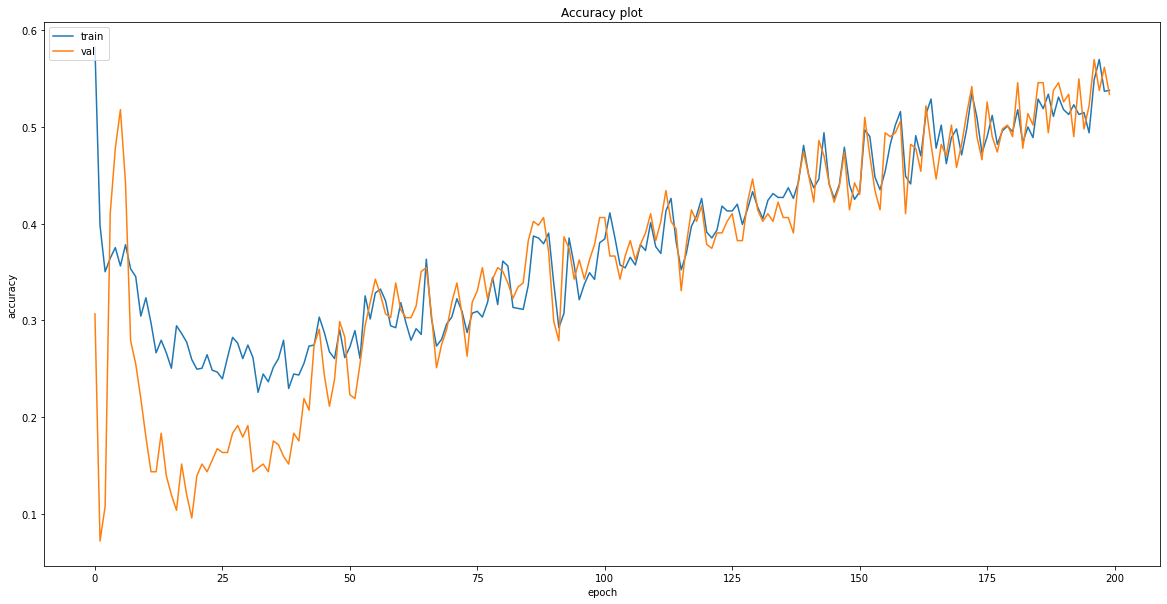

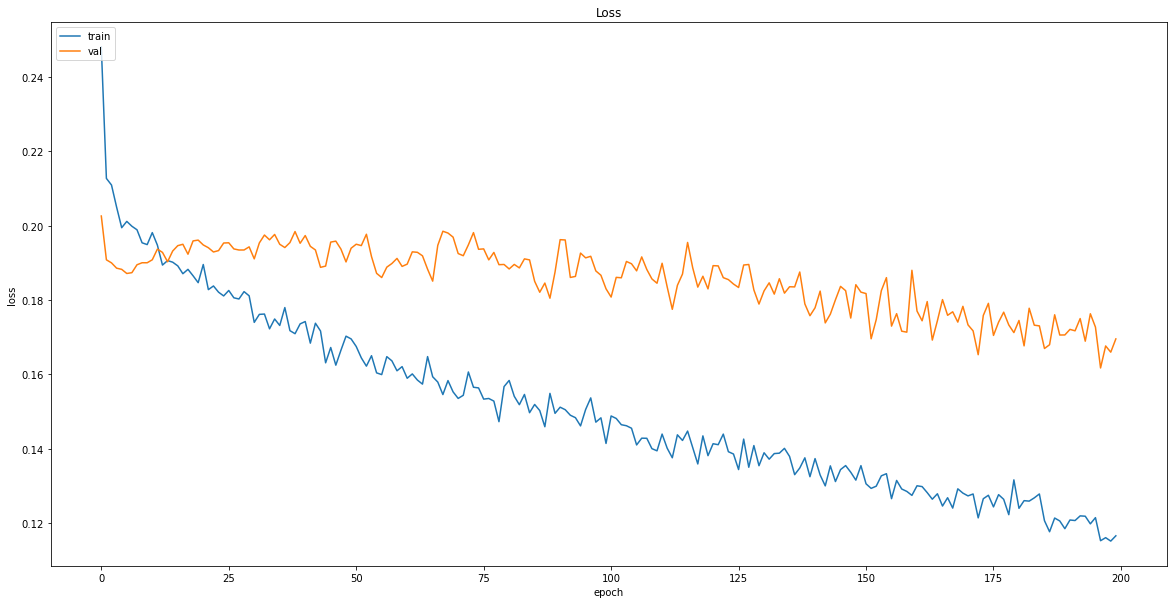

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
# Save model
model.save("models/{}".format('midea_time_series_cnn_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/midea_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

#### Non-Recession

In [72]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


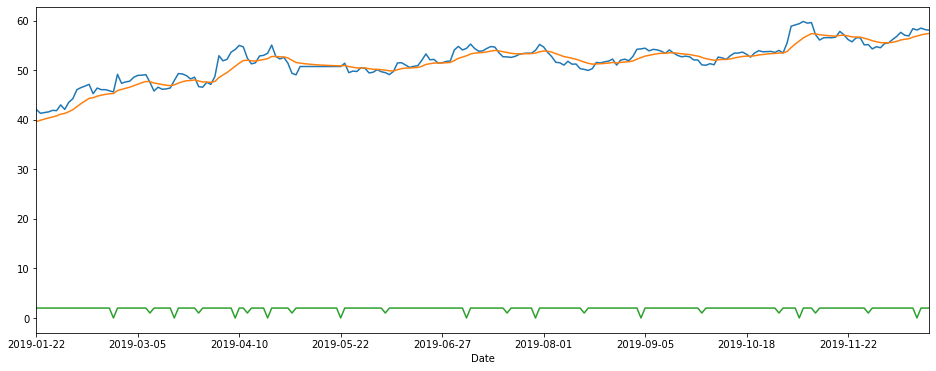

In [73]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [74]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [75]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [76]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [77]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [78]:
model = tf.keras.models.load_model("models/midea_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1777 - accuracy: 0.4300 - mean_squared_error: 1.8878 - weighted_accuracy: 0.4300 - weighted_mean_squared_error: 1.8878
Test loss: 0.177708238363266
Test accuracy: 0.4299516975879669


In [79]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 65, 0: 55, 2: 87})

In [80]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [81]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [82]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,1,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,0,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,2,2


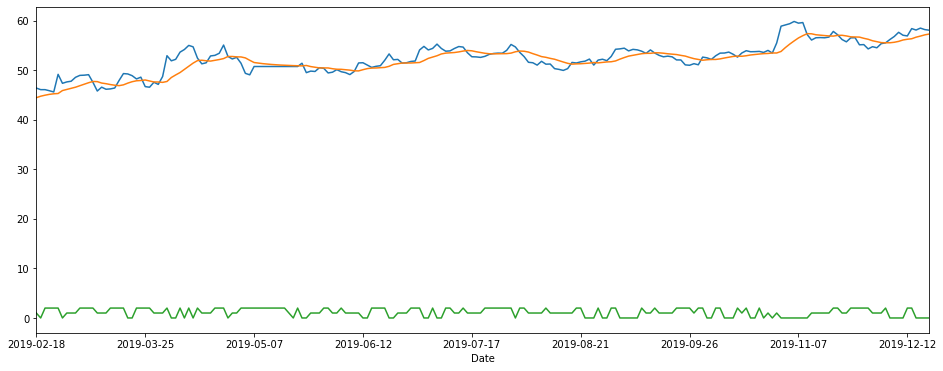

In [83]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

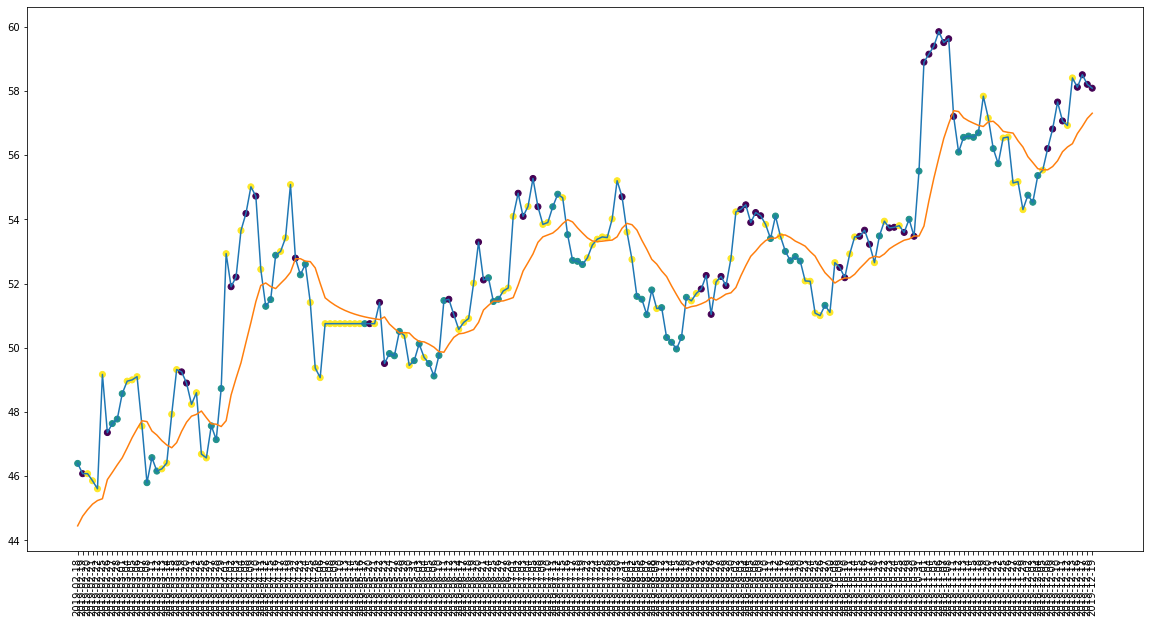

In [84]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

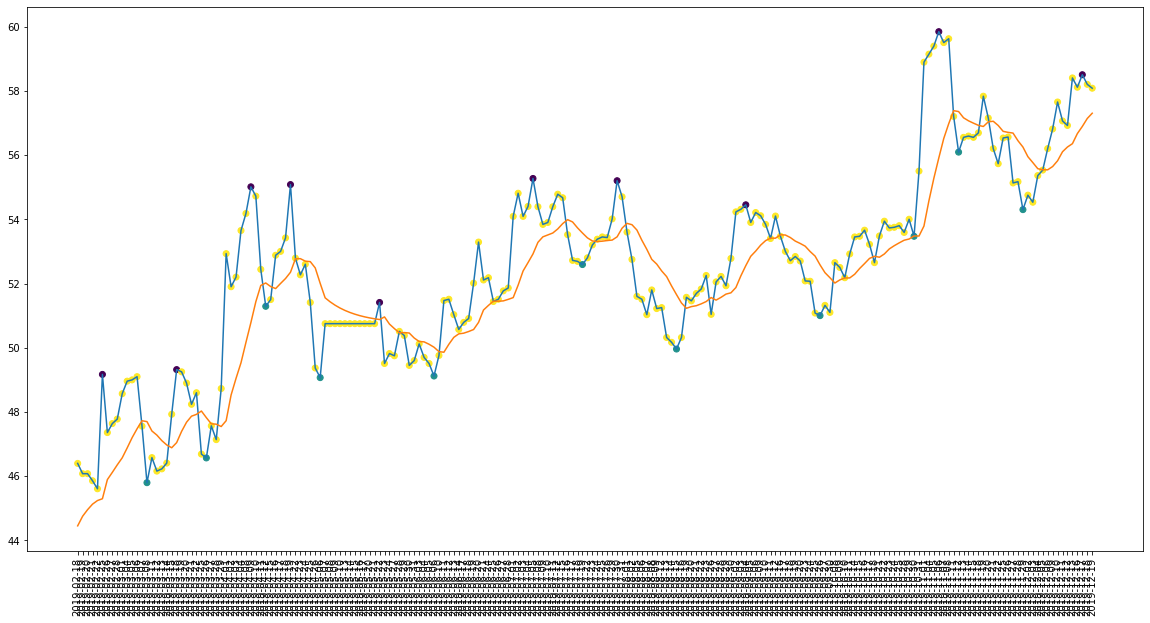

In [85]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [86]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 59
actual holds but predicted sell: 49
actual predicted holds: 78
Percentage buys correct: 54.54545454545455%
Percentage sells correct: 50.0%
Percentage holds correct: 41.935483870967744%
actual buys: 11
actual sells: 10
actual holds: 186


In [87]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 62.5%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 74.71264367816092%


In [88]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.4000015258789
Shares owned at the moment: 214
Cash capital at the moment: $43.0932725639359


Price increase from previously bought: 5.851147233895548%
Share price: $49.25
Shares owned at the moment: 0
Cash capital at the moment: $10553.609647563935


Share price: $47.56999969482422
Shares owned at the moment: 221
Cash capital at the moment: $11.72904769325396


Price increase from previously bought: 8.803170635037727%
Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $11450.087158985138


Share price: $51.290000915527344
Shares owned at the moment: 222
Cash capital at the moment: $32.394410179136685


Stop Loss Activated!

Share price: $49.36999893188477
Shares owned at the moment: 0
Cash capital at the moment: $10962.39378870964


Share price: $50.75
Shares owned at the moment: 215
Cash capital at the moment: $21.137851209639848


Stop Loss Activated!

Share price: $49.11999893188477
Shares owned at the moment: 0
Cash capital at

In [89]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


### Recession

In [90]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


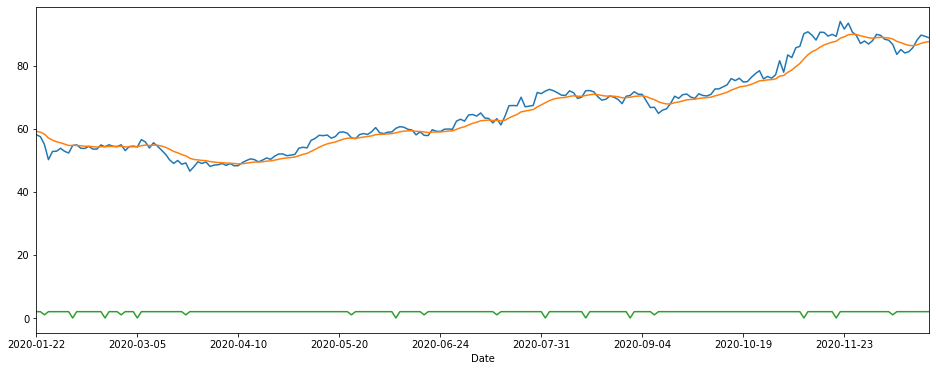

In [91]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [92]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [93]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [94]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [95]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [96]:
model = tf.keras.models.load_model("models/midea_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1772 - accuracy: 0.4663 - mean_squared_error: 1.8223 - weighted_accuracy: 0.4663 - weighted_mean_squared_error: 1.8223
Test loss: 0.1772320419549942
Test accuracy: 0.4663461446762085


In [97]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 94, 0: 70, 1: 44})

In [98]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [99]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [100]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,0,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,0,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,0,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,0,2


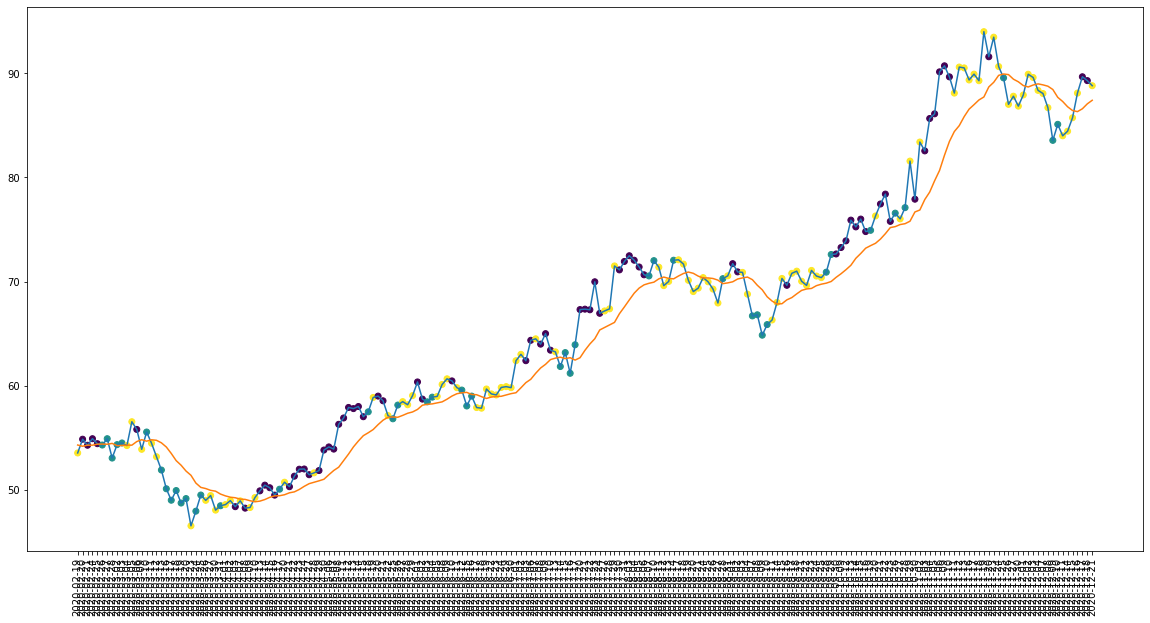

In [101]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

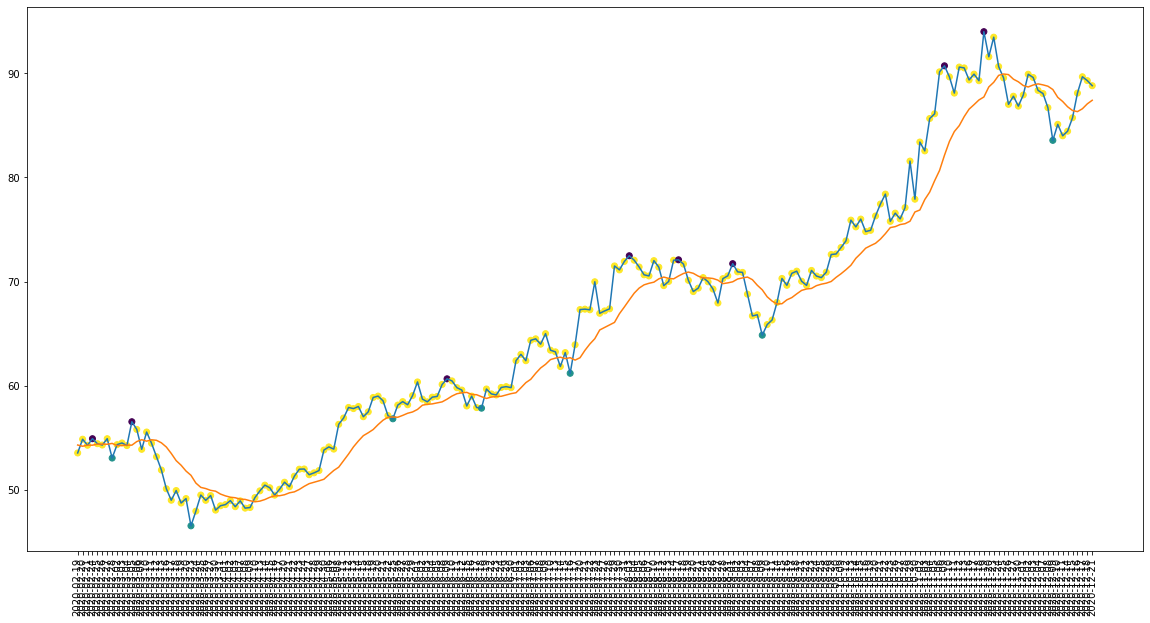

In [102]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [103]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 4
actual holds but predicted buy: 39
actual holds but predicted sell: 66
actual predicted holds: 88
Percentage buys correct: 71.42857142857143%
Percentage sells correct: 50.0%
Percentage holds correct: 45.59585492227979%
actual buys: 7
actual sells: 8
actual holds: 193


In [104]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 65.9090909090909%
Percentage sells correct: 54.285714285714285%
Percentage holds correct: 86.02150537634408%


In [105]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.29999923706055
Shares owned at the moment: 183
Cash capital at the moment: $35.77366500186872


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9507.355268469808


Share price: $51.9000015258789
Shares owned at the moment: 182
Cash capital at the moment: $35.57903999614609


Stop Loss Activated!

Share price: $50.099998474121094
Shares owned at the moment: 0
Cash capital at the moment: $9128.703713049887


Share price: $50.099998474121094
Shares owned at the moment: 181
Cash capital at the moment: $35.66671499347467


Stop Loss Activated!

Share price: $48.72999954223633
Shares owned at the moment: 0
Cash capital at the moment: $8831.541274866102


Share price: $48.72999954223633
Shares owned at the moment: 180
Cash capital at the moment: $36.02000749015497


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8390.18287183189


Share price: $47

In [106]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [107]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


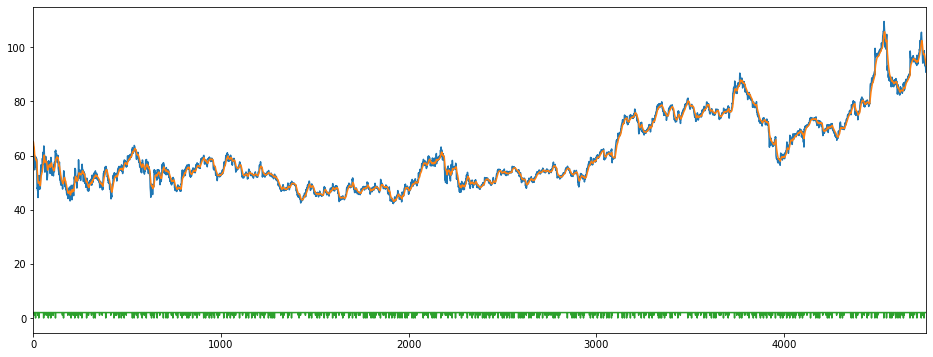

In [108]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [109]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [110]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [111]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [112]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [113]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [114]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [115]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [116]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [117]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.148775894538606, 1: 7.3565891472868215, 2: 0.3670824871869258}
Epoch 1/200
30/30 [==============================] - 2s 80ms/step - loss: 0.2185 - accuracy: 0.4428 - mse: 0.9606 - weighted_accuracy: 0.3221 - weighted_mse: 1.0161 - val_loss: 0.1824 - val_accuracy: 0.7134 - val_mse: 1.1144 - val_weighted_accuracy: 0.7134 - val_weighted_mse: 1.1144
Epoch 2/200
30/30 [==============================] - 0s 10ms/step - loss: 0.2052 - accuracy: 0.4692 - mse: 1.1475 - weighted_accuracy: 0.3671 - weighted_mse: 1.1864 - val_loss: 0.1850 - val_accuracy: 0.4847 - val_mse: 1.0324 - val_weighted_accuracy: 0.4847 - val_weighted_mse: 1.0324
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1981 - accuracy: 0.3793 - mse: 1.1561 - weighted_accuracy: 0.4031 - weighted_mse: 1.1571 - val_loss: 0.1878 - val_accuracy: 0.2561 - val_mse: 1.0987 - val_weighted_accuracy: 0.2561 - val_weighted_mse: 1.0987
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1954 

30/30 [==============================] - 0s 10ms/step - loss: 0.1677 - accuracy: 0.2545 - mse: 1.4421 - weighted_accuracy: 0.5727 - weighted_mse: 1.3657 - val_loss: 0.1977 - val_accuracy: 0.1970 - val_mse: 1.3844 - val_weighted_accuracy: 0.1970 - val_weighted_mse: 1.3844
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1691 - accuracy: 0.2302 - mse: 1.4405 - weighted_accuracy: 0.5476 - weighted_mse: 1.3621 - val_loss: 0.2045 - val_accuracy: 0.1475 - val_mse: 1.4272 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.4272
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1663 - accuracy: 0.2071 - mse: 1.4814 - weighted_accuracy: 0.5805 - weighted_mse: 1.3761 - val_loss: 0.2033 - val_accuracy: 0.1665 - val_mse: 1.4677 - val_weighted_accuracy: 0.1665 - val_weighted_mse: 1.4677
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1662 - accuracy: 0.2250 - mse: 1.4851 - weighted_accuracy: 0.5798 - weighted_mse: 1.

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1564 - accuracy: 0.2210 - mse: 1.6359 - weighted_accuracy: 0.6055 - weighted_mse: 1.5378 - val_loss: 0.1999 - val_accuracy: 0.1981 - val_mse: 1.5644 - val_weighted_accuracy: 0.1981 - val_weighted_mse: 1.5644
Epoch 58/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1543 - accuracy: 0.2619 - mse: 1.6683 - weighted_accuracy: 0.6314 - weighted_mse: 1.5796 - val_loss: 0.1992 - val_accuracy: 0.2266 - val_mse: 1.6205 - val_weighted_accuracy: 0.2266 - val_weighted_mse: 1.6205
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1565 - accuracy: 0.2864 - mse: 1.6609 - weighted_accuracy: 0.6130 - weighted_mse: 1.5901 - val_loss: 0.2005 - val_accuracy: 0.2129 - val_mse: 1.5849 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.5849
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1564 - accuracy: 0.2376 - mse: 1.6689 - weighted_accuracy: 0.6298 - 

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1492 - accuracy: 0.2782 - mse: 1.7715 - weighted_accuracy: 0.6626 - weighted_mse: 1.6795 - val_loss: 0.1954 - val_accuracy: 0.2529 - val_mse: 1.7041 - val_weighted_accuracy: 0.2529 - val_weighted_mse: 1.7041
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1479 - accuracy: 0.2616 - mse: 1.7457 - weighted_accuracy: 0.6510 - weighted_mse: 1.6610 - val_loss: 0.2026 - val_accuracy: 0.2192 - val_mse: 1.7694 - val_weighted_accuracy: 0.2192 - val_weighted_mse: 1.7694
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1499 - accuracy: 0.2513 - mse: 1.8099 - weighted_accuracy: 0.6382 - weighted_mse: 1.7089 - val_loss: 0.1988 - val_accuracy: 0.2297 - val_mse: 1.6560 - val_weighted_accuracy: 0.2297 - val_weighted_mse: 1.6560
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1468 - accuracy: 0.2837 - mse: 1.7835 - weighted_accuracy: 0.6553 - weig

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1414 - accuracy: 0.3080 - mse: 1.9241 - weighted_accuracy: 0.6718 - weighted_mse: 1.8755 - val_loss: 0.2038 - val_accuracy: 0.2266 - val_mse: 1.8388 - val_weighted_accuracy: 0.2266 - val_weighted_mse: 1.8388
Epoch 116/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1422 - accuracy: 0.2798 - mse: 1.9325 - weighted_accuracy: 0.6687 - weighted_mse: 1.8569 - val_loss: 0.1917 - val_accuracy: 0.2835 - val_mse: 1.8405 - val_weighted_accuracy: 0.2835 - val_weighted_mse: 1.8405
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1402 - accuracy: 0.3098 - mse: 1.9467 - weighted_accuracy: 0.6687 - weighted_mse: 1.9008 - val_loss: 0.1950 - val_accuracy: 0.2740 - val_mse: 1.9358 - val_weighted_accuracy: 0.2740 - val_weighted_mse: 1.9358
Epoch 118/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1402 - accuracy: 0.2761 - mse: 1.9714 - weighted_accuracy: 0.6782

Epoch 144/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1331 - accuracy: 0.3707 - mse: 2.1363 - weighted_accuracy: 0.7128 - weighted_mse: 2.1717 - val_loss: 0.1916 - val_accuracy: 0.3193 - val_mse: 2.0920 - val_weighted_accuracy: 0.3193 - val_weighted_mse: 2.0920
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1330 - accuracy: 0.3367 - mse: 2.2153 - weighted_accuracy: 0.7077 - weighted_mse: 2.2285 - val_loss: 0.1943 - val_accuracy: 0.3077 - val_mse: 2.0698 - val_weighted_accuracy: 0.3077 - val_weighted_mse: 2.0698
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1323 - accuracy: 0.3564 - mse: 2.1167 - weighted_accuracy: 0.7037 - weighted_mse: 2.1372 - val_loss: 0.2030 - val_accuracy: 0.2824 - val_mse: 2.1146 - val_weighted_accuracy: 0.2824 - val_weighted_mse: 2.1146
Epoch 147/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1331 - accuracy: 0.3717 - mse: 2.1830 - weighted_accuracy: 0.7095

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1271 - accuracy: 0.4023 - mse: 2.3280 - weighted_accuracy: 0.7406 - weighted_mse: 2.3870 - val_loss: 0.1889 - val_accuracy: 0.3625 - val_mse: 2.2875 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 2.2875
Epoch 174/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1269 - accuracy: 0.4107 - mse: 2.2997 - weighted_accuracy: 0.7311 - weighted_mse: 2.3714 - val_loss: 0.1970 - val_accuracy: 0.3319 - val_mse: 2.2402 - val_weighted_accuracy: 0.3319 - val_weighted_mse: 2.2402
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1263 - accuracy: 0.4315 - mse: 2.3986 - weighted_accuracy: 0.7349 - weighted_mse: 2.4486 - val_loss: 0.1876 - val_accuracy: 0.3836 - val_mse: 2.3615 - val_weighted_accuracy: 0.3836 - val_weighted_mse: 2.3615
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1243 - accuracy: 0.4281 - mse: 2.5004 - weighted_accuracy: 0.7339 -

In [118]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18518564105033875
Test accuracy: 0.4225500524044037


In [119]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.7527182  -0.53375334 -0.29057512]
 [-1.0112998  -1.0116222  -0.3759278 ]
 [ 0.07185788 -2.7759485  -0.82616794]
 ...
 [-2.8137467  -0.44150516 -0.43381205]
 [-0.10706117 -1.7904408  -0.6149996 ]
 [-0.34733218 -1.8363485  -0.44868308]]


Counter({2: 374, 0: 269, 1: 306})

In [120]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [121]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 30
actual buys but predicted sell: 0
actual buys but predicted hold: 13
actual sells but predicted buy: 2
actual predicted sells: 26
actual sells but predicted hold: 16
actual holds but predicted buy: 274
actual holds but predicted sell: 243
actual predicted holds: 345
Percentage buys correct: 69.76744186046511%
Percentage sells correct: 59.09090909090909%
Percentage holds correct: 40.02320185614849%
actual buys: 43
actual sells: 44
actual holds: 862


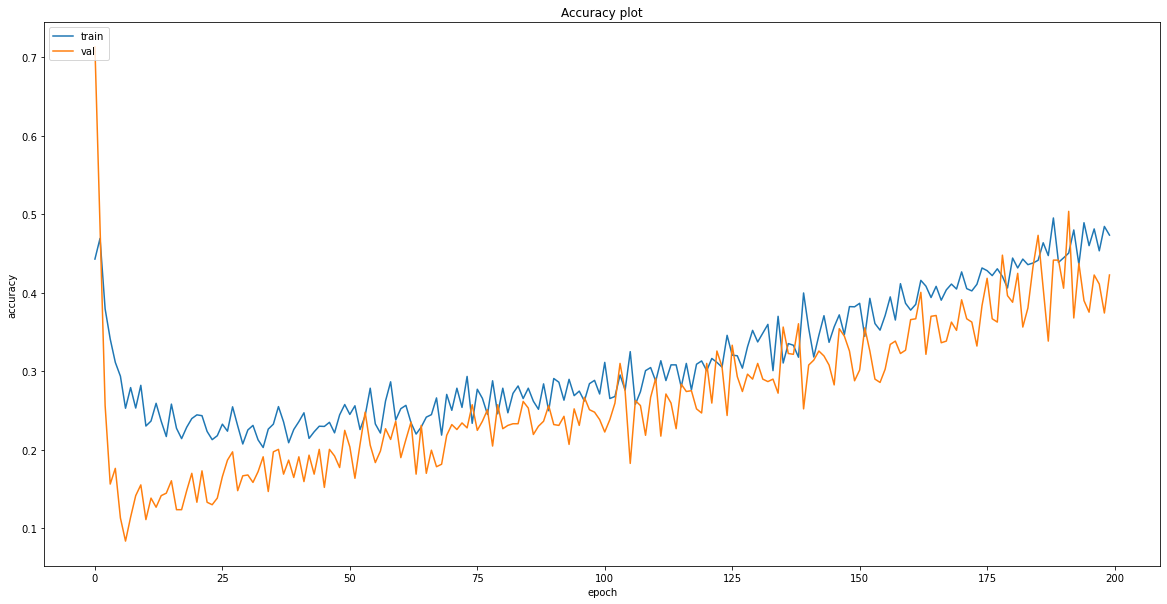

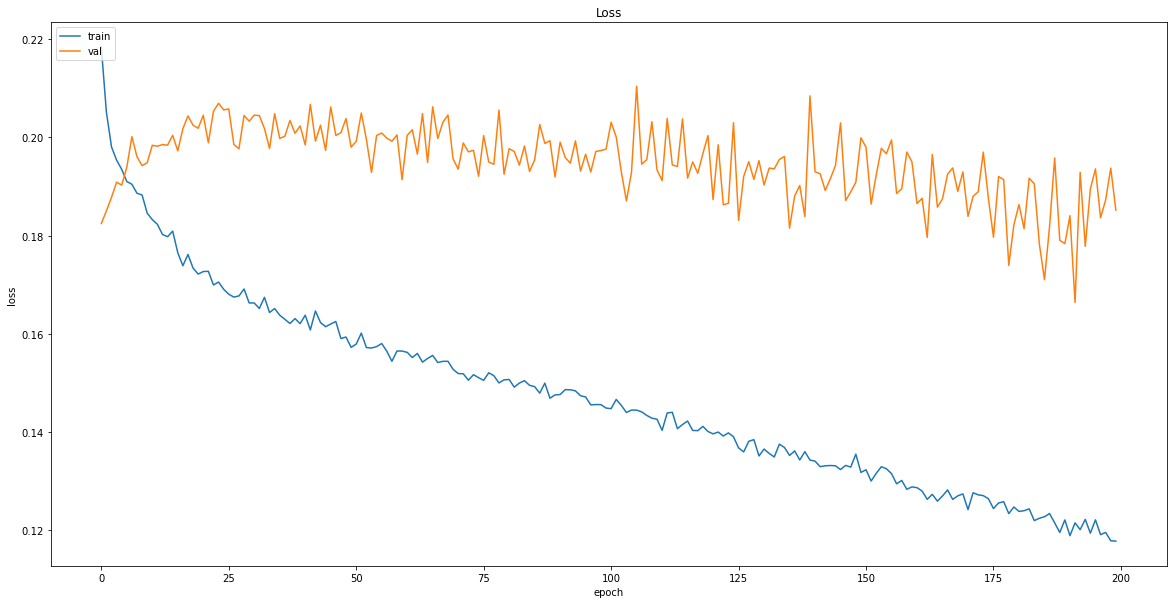

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [130]:
# Save model
model.save("models/{}".format('wmt_time_series_cnn_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/wmt_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [124]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


In [125]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [126]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [127]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [128]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [131]:
model = tf.keras.models.load_model("models/wmt_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1811 - accuracy: 0.3670 - mean_squared_error: 2.3854 - weighted_accuracy: 0.3670 - weighted_mean_squared_error: 2.3854
Test loss: 0.18107779324054718
Test accuracy: 0.3669724762439728


In [132]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 78, 0: 79, 1: 61})

In [133]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [134]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/wmt_data_test.csv")
df.set_index('Date', inplace=True)

In [135]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,0,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,0,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,0,2


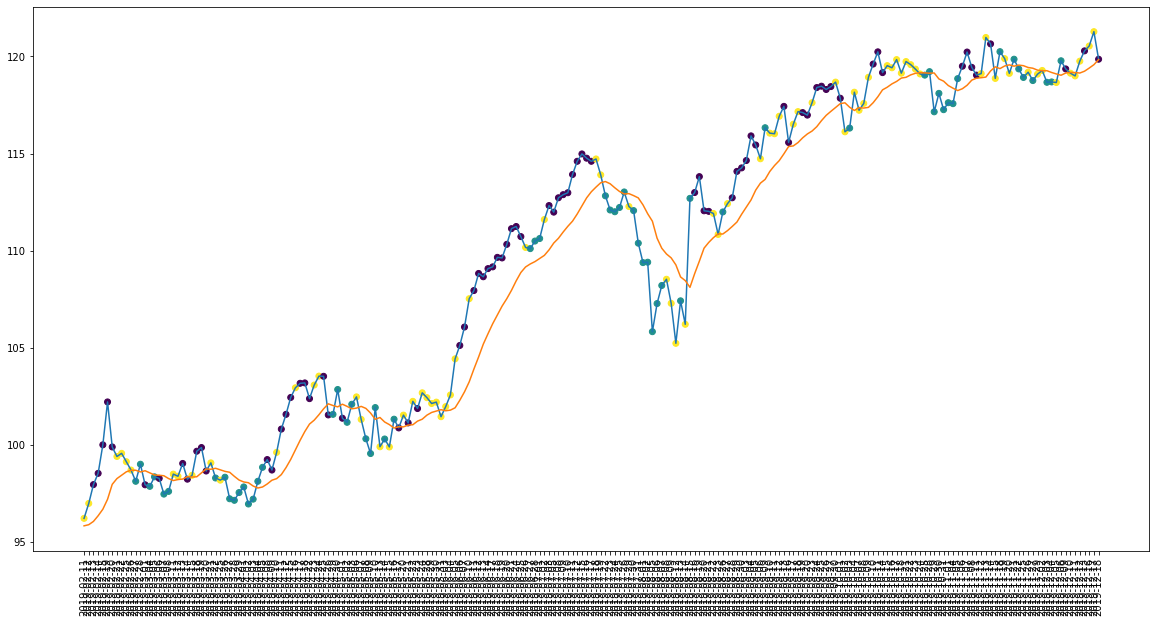

In [136]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

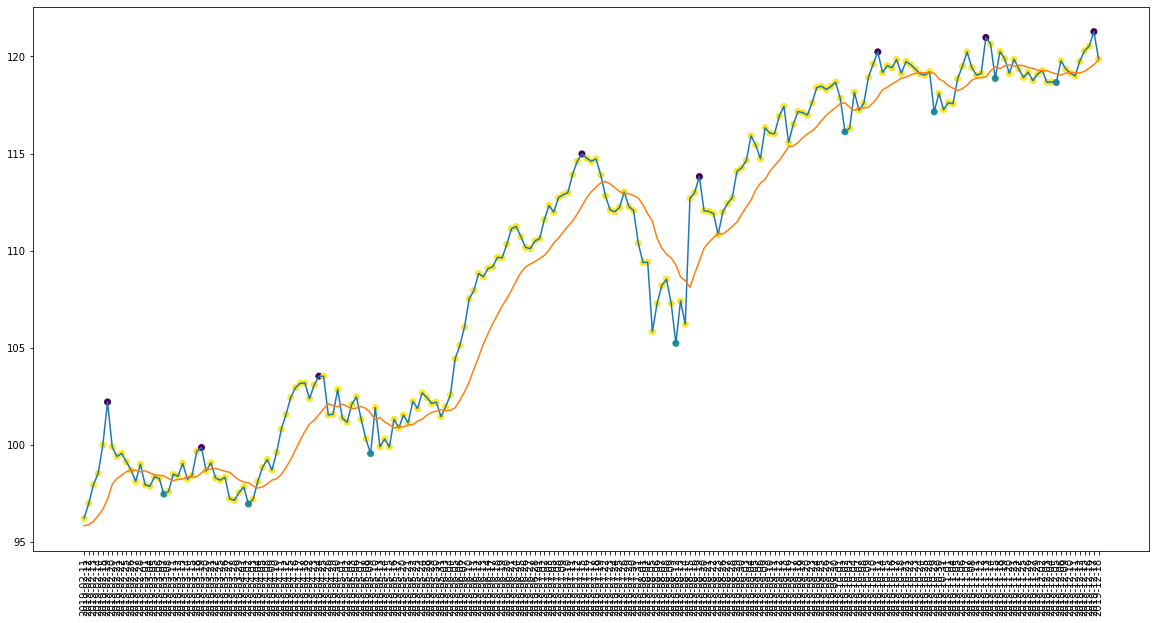

In [137]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [138]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 74
actual predicted holds: 71
Percentage buys correct: 50.0%
Percentage sells correct: 62.5%
Percentage holds correct: 35.148514851485146%
actual buys: 8
actual sells: 8
actual holds: 202


In [139]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 57.377049180327866%
Percentage sells correct: 49.36708860759494%
Percentage holds correct: 83.11688311688312%


In [140]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $98.11000061035156
Shares owned at the moment: 101
Cash capital at the moment: $63.63988568496643


Price increase from previously bought: 5.224846328654453%
Share price: $103.5199966430664
Shares owned at the moment: 0
Cash capital at the moment: $10490.40686756706


Share price: $101.55999755859376
Shares owned at the moment: 103
Cash capital at the moment: $0.9602497234300245


Price increase from previously bought: 5.990531784129427%
Share price: $107.94000244140624
Shares owned at the moment: 0
Cash capital at the moment: $11088.206495496743


Share price: $110.0999984741211
Shares owned at the moment: 100
Cash capital at the moment: $47.929148504250406


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10600.828618070595


Share price: $105.81999969482422
Shares owned at the moment: 99
Cash capital at the moment: $95.83915336608152


Price increase from previously bought: 6.482827289801785%
Share price:

In [141]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### recession

In [142]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [143]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [144]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [145]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [146]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [147]:
model = tf.keras.models.load_model("models/wmt_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1746 - accuracy: 0.4840 - mean_squared_error: 2.5678 - weighted_accuracy: 0.4840 - weighted_mean_squared_error: 2.5678
Test loss: 0.1745954155921936
Test accuracy: 0.4840182662010193


In [148]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 96, 1: 76, 0: 47})

In [149]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [150]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [151]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,1,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,0,0


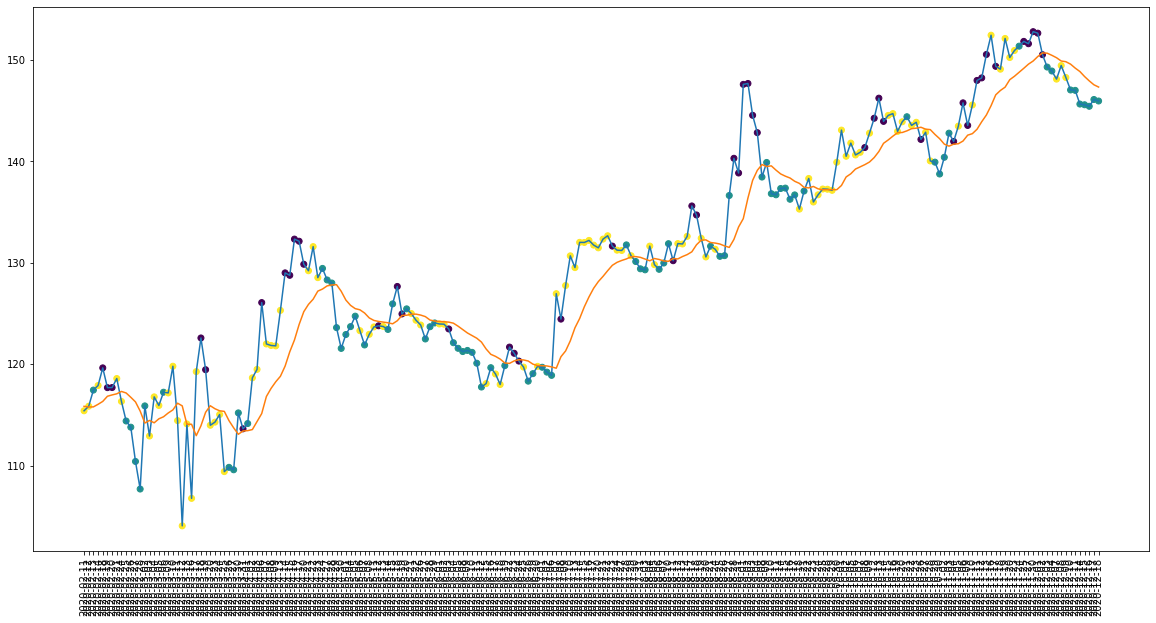

In [152]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

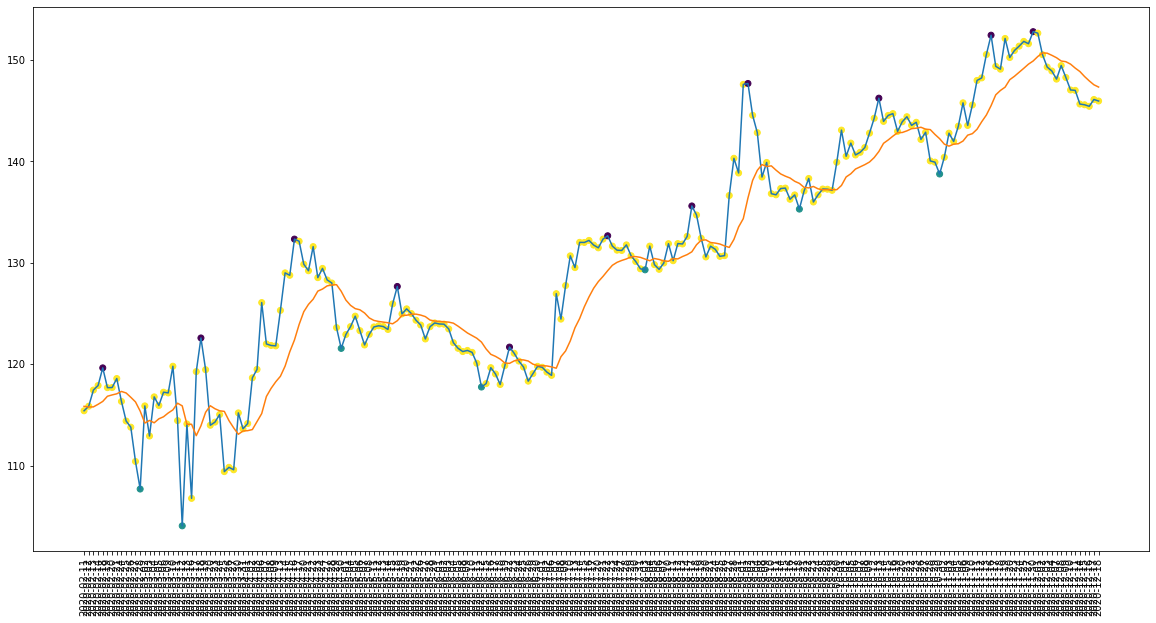

In [153]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [154]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 71
actual holds but predicted sell: 38
actual predicted holds: 92
Percentage buys correct: 71.42857142857143%
Percentage sells correct: 81.81818181818181%
Percentage holds correct: 45.77114427860697%
actual buys: 7
actual sells: 11
actual holds: 201


In [155]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 57.333333333333336%
Percentage sells correct: 61.702127659574465%
Percentage holds correct: 88.54166666666667%


In [156]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $117.44000244140624
Shares owned at the moment: 84
Cash capital at the moment: $107.91115435791107


Stop Loss Activated!

Share price: $113.77999877929688
Shares owned at the moment: 0
Cash capital at the moment: $9639.147872100832


Share price: $113.77999877929688
Shares owned at the moment: 84
Cash capital at the moment: $55.34479492187711


Stop Loss Activated!

Share price: $110.4000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9303.442522743228


Share price: $110.4000015258789
Shares owned at the moment: 84
Cash capital at the moment: $4.339994216921696


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $8720.504699859619


Share price: $109.81999969482422
Shares owned at the moment: 79
Cash capital at the moment: $20.86632903480495


Price increase from previously bought: 14.482114673771761%
Share price: $126.06999969482422
Shares owned at the moment: 0
Cash capital at the moment

In [157]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [158]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


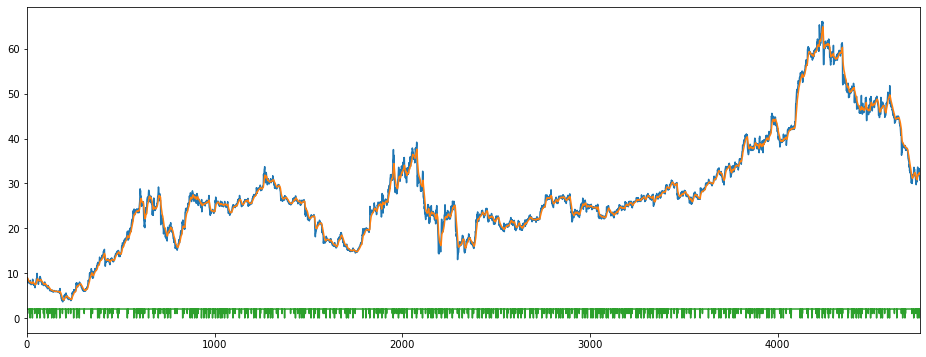

In [159]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [160]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [161]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [162]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [163]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)
X.shape

(4745, 64, 64, 1)

In [164]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [165]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [166]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [167]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [168]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.1893939393939394, 2: 0.3671890114142}
Epoch 1/200
30/30 [==============================] - 3s 104ms/step - loss: 0.2184 - accuracy: 0.4884 - mse: 0.9599 - weighted_accuracy: 0.3215 - weighted_mse: 1.0217 - val_loss: 0.1826 - val_accuracy: 0.6080 - val_mse: 1.1302 - val_weighted_accuracy: 0.6080 - val_weighted_mse: 1.1302
Epoch 2/200
30/30 [==============================] - 0s 15ms/step - loss: 0.2047 - accuracy: 0.4694 - mse: 1.1496 - weighted_accuracy: 0.3671 - weighted_mse: 1.1873 - val_loss: 0.1849 - val_accuracy: 0.6006 - val_mse: 1.0437 - val_weighted_accuracy: 0.6006 - val_weighted_mse: 1.0437
Epoch 3/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1980 - accuracy: 0.4183 - mse: 1.1400 - weighted_accuracy: 0.4029 - weighted_mse: 1.1399 - val_loss: 0.1852 - val_accuracy: 0.4721 - val_mse: 1.0935 - val_weighted_accuracy: 0.4721 - val_weighted_mse: 1.0935
Epoch 4/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1966 

30/30 [==============================] - 0s 16ms/step - loss: 0.1758 - accuracy: 0.2458 - mse: 1.3745 - weighted_accuracy: 0.5494 - weighted_mse: 1.3080 - val_loss: 0.1953 - val_accuracy: 0.1623 - val_mse: 1.3091 - val_weighted_accuracy: 0.1623 - val_weighted_mse: 1.3091
Epoch 29/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1754 - accuracy: 0.2429 - mse: 1.3494 - weighted_accuracy: 0.5339 - weighted_mse: 1.2777 - val_loss: 0.1990 - val_accuracy: 0.1307 - val_mse: 1.3175 - val_weighted_accuracy: 0.1307 - val_weighted_mse: 1.3175
Epoch 30/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1738 - accuracy: 0.1973 - mse: 1.3817 - weighted_accuracy: 0.5459 - weighted_mse: 1.3000 - val_loss: 0.1998 - val_accuracy: 0.1454 - val_mse: 1.3815 - val_weighted_accuracy: 0.1454 - val_weighted_mse: 1.3815
Epoch 31/200
30/30 [==============================] - 0s 15ms/step - loss: 0.1730 - accuracy: 0.2142 - mse: 1.4097 - weighted_accuracy: 0.5722 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1636 - accuracy: 0.2226 - mse: 1.5152 - weighted_accuracy: 0.5861 - weighted_mse: 1.4129 - val_loss: 0.1980 - val_accuracy: 0.2023 - val_mse: 1.4544 - val_weighted_accuracy: 0.2023 - val_weighted_mse: 1.4544
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1627 - accuracy: 0.2584 - mse: 1.4744 - weighted_accuracy: 0.5830 - weighted_mse: 1.4082 - val_loss: 0.1996 - val_accuracy: 0.2055 - val_mse: 1.4833 - val_weighted_accuracy: 0.2055 - val_weighted_mse: 1.4833
Epoch 59/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1644 - accuracy: 0.2403 - mse: 1.5181 - weighted_accuracy: 0.5764 - weighted_mse: 1.4409 - val_loss: 0.2017 - val_accuracy: 0.1791 - val_mse: 1.4353 - val_weighted_accuracy: 0.1791 - val_weighted_mse: 1.4353
Epoch 60/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1647 - accuracy: 0.2139 - mse: 1.4960 - weighted_accuracy: 0.5774 - w

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1573 - accuracy: 0.2489 - mse: 1.6372 - weighted_accuracy: 0.6211 - weighted_mse: 1.5243 - val_loss: 0.1984 - val_accuracy: 0.2329 - val_mse: 1.5721 - val_weighted_accuracy: 0.2329 - val_weighted_mse: 1.5721
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1552 - accuracy: 0.2698 - mse: 1.5644 - weighted_accuracy: 0.6217 - weighted_mse: 1.4807 - val_loss: 0.1971 - val_accuracy: 0.2276 - val_mse: 1.5073 - val_weighted_accuracy: 0.2276 - val_weighted_mse: 1.5073
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1586 - accuracy: 0.2642 - mse: 1.5733 - weighted_accuracy: 0.6195 - weighted_mse: 1.4901 - val_loss: 0.1992 - val_accuracy: 0.2065 - val_mse: 1.5146 - val_weighted_accuracy: 0.2065 - val_weighted_mse: 1.5146
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1558 - accuracy: 0.2587 - mse: 1.5978 - weighted_accuracy: 0.6284 - weig

Epoch 115/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1498 - accuracy: 0.2871 - mse: 1.6836 - weighted_accuracy: 0.6496 - weighted_mse: 1.6230 - val_loss: 0.2040 - val_accuracy: 0.2202 - val_mse: 1.6564 - val_weighted_accuracy: 0.2202 - val_weighted_mse: 1.6564
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1491 - accuracy: 0.2371 - mse: 1.6876 - weighted_accuracy: 0.6548 - weighted_mse: 1.5856 - val_loss: 0.1988 - val_accuracy: 0.2350 - val_mse: 1.6451 - val_weighted_accuracy: 0.2350 - val_weighted_mse: 1.6451
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1488 - accuracy: 0.3003 - mse: 1.6452 - weighted_accuracy: 0.6564 - weighted_mse: 1.5822 - val_loss: 0.1996 - val_accuracy: 0.2413 - val_mse: 1.7126 - val_weighted_accuracy: 0.2413 - val_weighted_mse: 1.7126
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1488 - accuracy: 0.2529 - mse: 1.6965 - weighted_accuracy: 0.6569 -

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1401 - accuracy: 0.3267 - mse: 1.8654 - weighted_accuracy: 0.6876 - weighted_mse: 1.7869 - val_loss: 0.2021 - val_accuracy: 0.2677 - val_mse: 1.8209 - val_weighted_accuracy: 0.2677 - val_weighted_mse: 1.8209
Epoch 145/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1383 - accuracy: 0.3174 - mse: 1.8668 - weighted_accuracy: 0.6952 - weighted_mse: 1.8288 - val_loss: 0.2068 - val_accuracy: 0.2687 - val_mse: 1.8769 - val_weighted_accuracy: 0.2687 - val_weighted_mse: 1.8769
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1395 - accuracy: 0.3217 - mse: 1.8962 - weighted_accuracy: 0.6858 - weighted_mse: 1.8489 - val_loss: 0.1986 - val_accuracy: 0.2961 - val_mse: 1.8324 - val_weighted_accuracy: 0.2961 - val_weighted_mse: 1.8324
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1398 - accuracy: 0.3190 - mse: 1.8681 - weighted_accuracy: 0.6868 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1327 - accuracy: 0.3949 - mse: 2.0509 - weighted_accuracy: 0.7182 - weighted_mse: 2.0508 - val_loss: 0.2044 - val_accuracy: 0.3066 - val_mse: 2.0271 - val_weighted_accuracy: 0.3066 - val_weighted_mse: 2.0271
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1325 - accuracy: 0.3793 - mse: 2.0490 - weighted_accuracy: 0.7215 - weighted_mse: 2.0407 - val_loss: 0.2034 - val_accuracy: 0.2993 - val_mse: 2.0278 - val_weighted_accuracy: 0.2993 - val_weighted_mse: 2.0278
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1325 - accuracy: 0.3701 - mse: 2.0786 - weighted_accuracy: 0.7218 - weighted_mse: 2.0716 - val_loss: 0.1927 - val_accuracy: 0.3393 - val_mse: 1.9497 - val_weighted_accuracy: 0.3393 - val_weighted_mse: 1.9497
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1319 - accuracy: 0.3796 - mse: 2.0234 - weighted_accuracy: 0.7216 - 

In [169]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.192420095205307
Test accuracy: 0.3867228627204895


In [170]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.7065846  -0.39741653 -0.45864177]
 [ 0.15627429 -2.3368297  -0.81150544]
 [-1.7599508  -0.1672109  -0.55946267]
 ...
 [-0.02537923 -2.005134   -0.6150311 ]
 [ 0.08710695 -2.5935125  -0.7251153 ]
 [-0.62884974 -1.1192281  -0.52736926]]


Counter({1: 350, 0: 249, 2: 350})

In [171]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [172]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 949
actual predicted buys: 26
actual buys but predicted sell: 4
actual buys but predicted hold: 14
actual sells but predicted buy: 6
actual predicted sells: 21
actual sells but predicted hold: 16
actual holds but predicted buy: 318
actual holds but predicted sell: 224
actual predicted holds: 320
Percentage buys correct: 59.09090909090909%
Percentage sells correct: 48.83720930232558%
Percentage holds correct: 37.12296983758701%
actual buys: 44
actual sells: 43
actual holds: 862


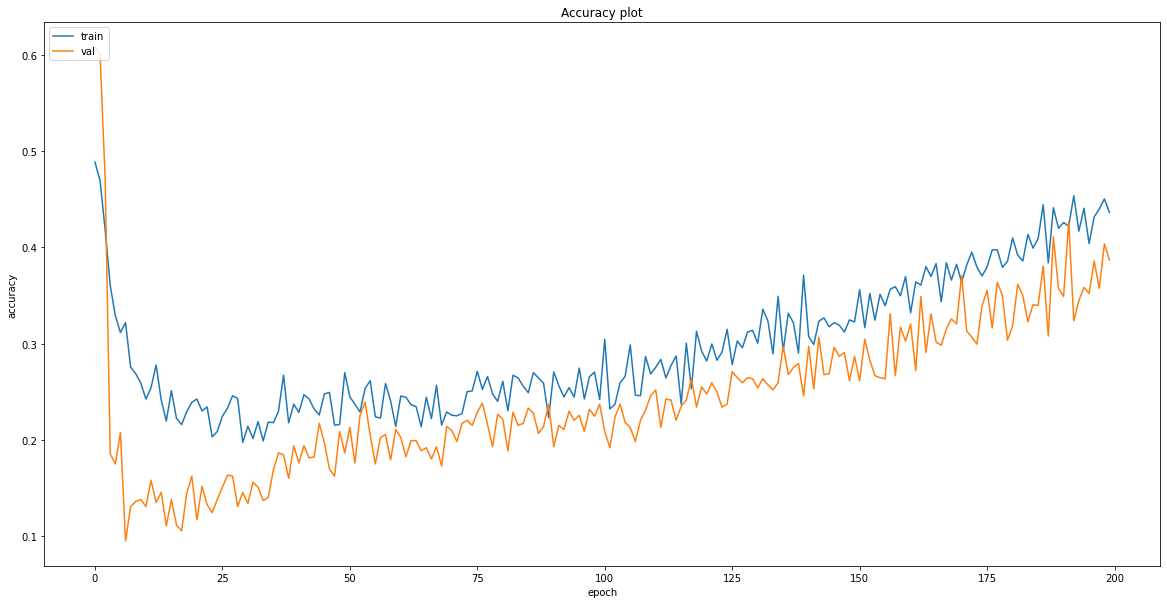

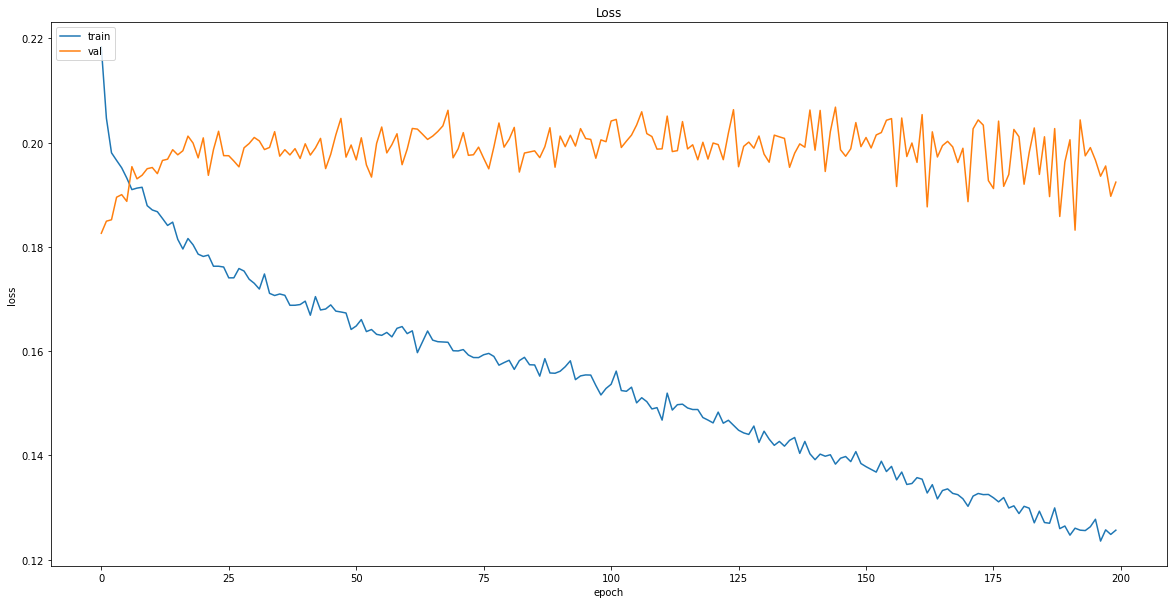

In [173]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [174]:
# Save model
model.save("models/{}".format('fdp_time_series_cnn_buy_hold_sell_original.model'))

INFO:tensorflow:Assets written to: models/fdp_time_series_cnn_buy_hold_sell_original.model\assets


### Test Performance

### non-recession

In [175]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [176]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [177]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [178]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [179]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [180]:
model = tf.keras.models.load_model("models/fdp_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1837 - accuracy: 0.4174 - mean_squared_error: 2.0753 - weighted_accuracy: 0.4174 - weighted_mean_squared_error: 2.0753
Test loss: 0.1837390512228012
Test accuracy: 0.41743120551109314


In [181]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 58, 2: 80, 1: 80})

In [182]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 198, 0: 10, 1: 10})

In [183]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [184]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,0,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,0,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,0,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


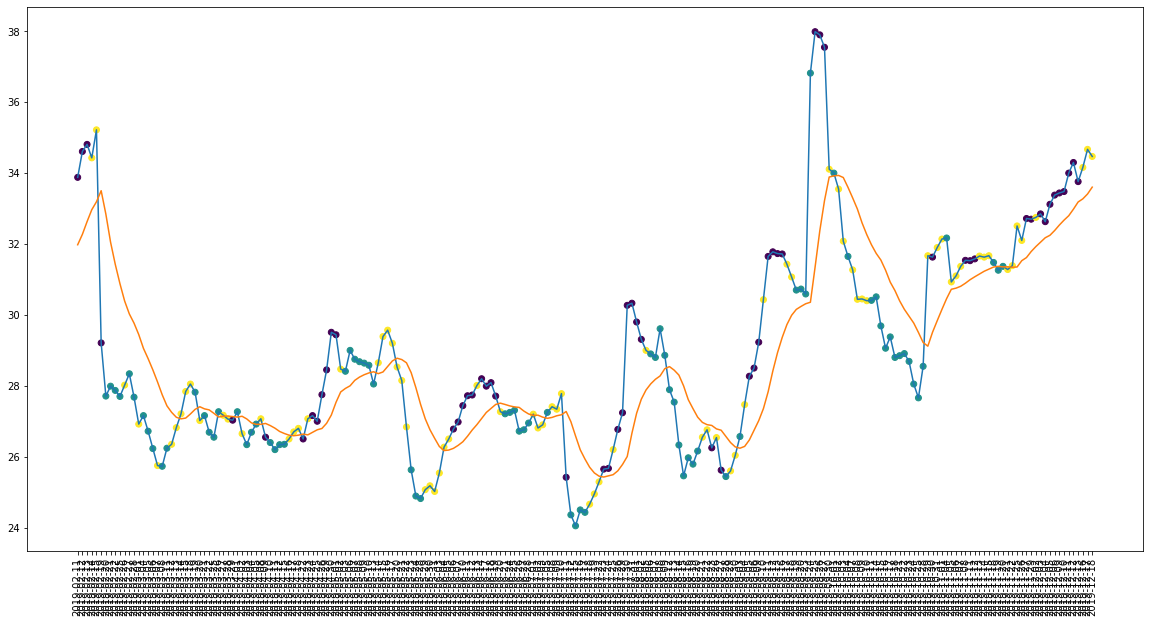

In [185]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

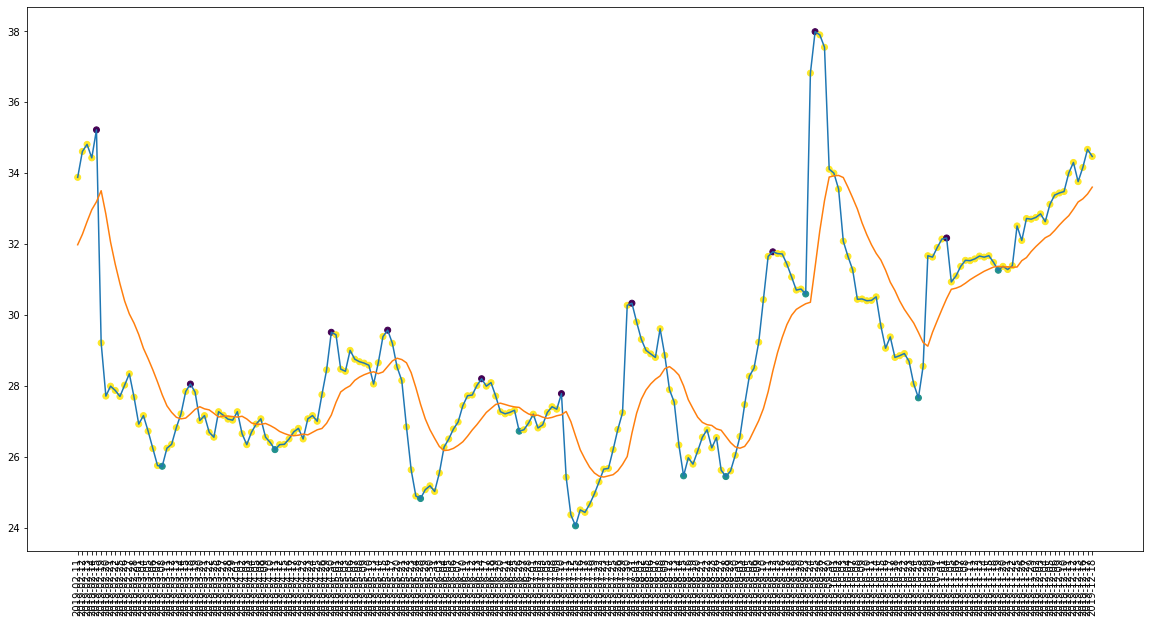

In [186]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [187]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 69
actual holds but predicted sell: 53
actual predicted holds: 76
Percentage buys correct: 100.0%
Percentage sells correct: 50.0%
Percentage holds correct: 38.38383838383838%
actual buys: 10
actual sells: 10
actual holds: 198


In [188]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 57.5%
Percentage sells correct: 44.827586206896555%
Percentage holds correct: 88.60759493670886%


In [189]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.709999084472656
Shares owned at the moment: 359
Cash capital at the moment: $24.753632078170995


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9662.456889392375


Share price: $27.15999984741211
Shares owned at the moment: 354
Cash capital at the moment: $21.376683557033175


Stop Loss Activated!

Share price: $26.229999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9281.261616954325


Share price: $26.229999542236328
Shares owned at the moment: 352
Cash capital at the moment: $22.911138530253083


Price increase from previously bought: 5.504755115542759%
Share price: $27.75
Shares owned at the moment: 0
Cash capital at the moment: $9764.049138530252


Share price: $28.40999984741211
Shares owned at the moment: 342
Cash capital at the moment: $21.109585858819628


Stop Loss Activated!

Share price: $26.84000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9175

In [190]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [191]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [192]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [193]:
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []

In [194]:
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [195]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [196]:
model = tf.keras.models.load_model("models/fdp_time_series_cnn_buy_hold_sell_original.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 4ms/step - loss: 0.1850 - accuracy: 0.4018 - mean_squared_error: 2.0955 - weighted_accuracy: 0.4018 - weighted_mean_squared_error: 2.0955
Test loss: 0.1850217878818512
Test accuracy: 0.4018264710903168


In [197]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 85, 0: 45, 1: 89})

In [198]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 199, 0: 10, 1: 10})

In [199]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [200]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,2,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,0,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,0,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,0,2


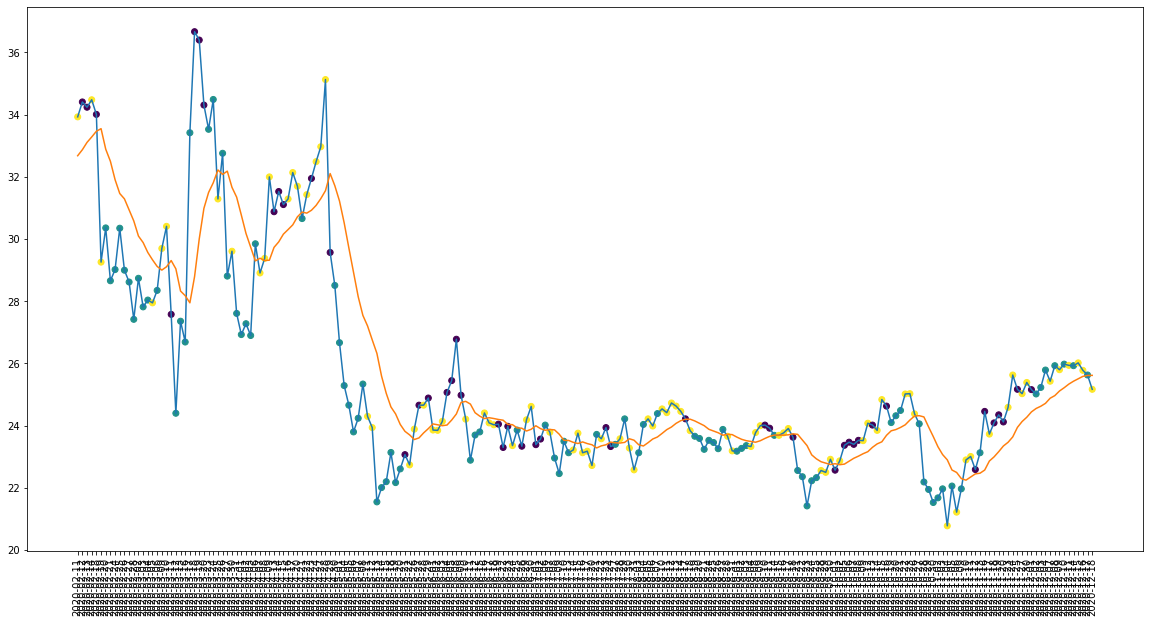

In [201]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

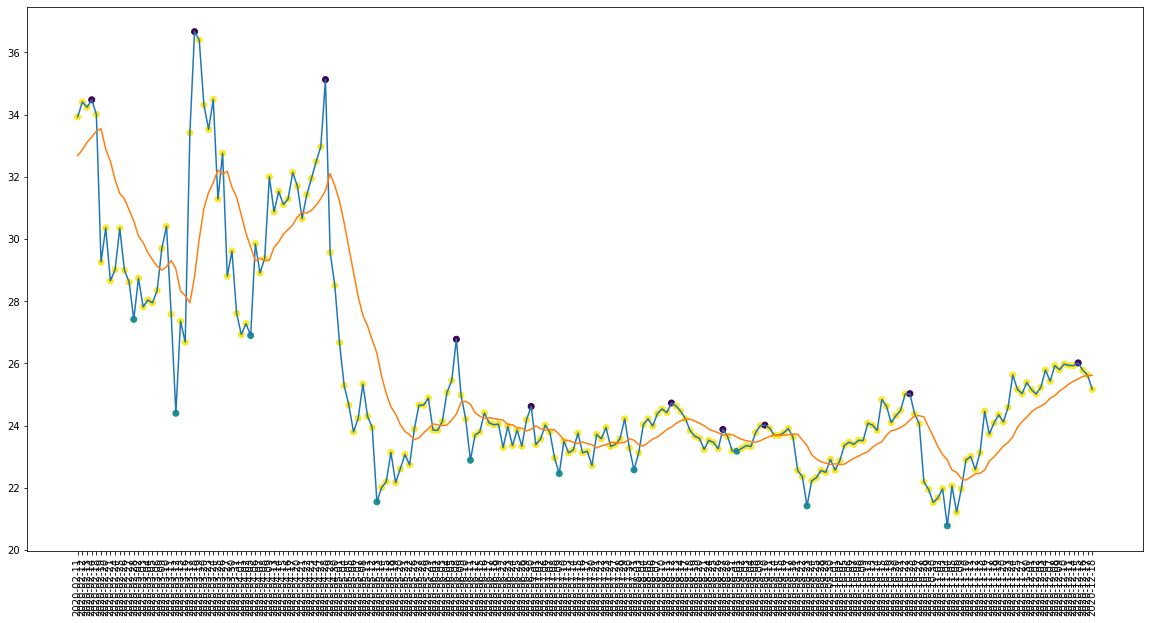

In [202]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [203]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 80
actual holds but predicted sell: 42
actual predicted holds: 77
Percentage buys correct: 80.0%
Percentage sells correct: 30.0%
Percentage holds correct: 38.69346733668342%
actual buys: 10
actual sells: 10
actual holds: 199


In [204]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 57.95454545454545%
Percentage sells correct: 48.888888888888886%
Percentage holds correct: 78.82352941176471%


In [205]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $30.36000061035156
Shares owned at the moment: 328
Cash capital at the moment: $14.535079254152151


Stop Loss Activated!

Share price: $28.65999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9389.163709342958


Share price: $28.65999984741211
Shares owned at the moment: 326
Cash capital at the moment: $20.310069223405662


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8934.648064026835


Share price: $27.420000076293945
Shares owned at the moment: 324
Cash capital at the moment: $26.13681923961849


Stop Loss Activated!

Share price: $24.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $7909.9962959833165


Share price: $24.399999618530273
Shares owned at the moment: 323
Cash capital at the moment: $7.123119536878221


Price increase from previously bought: 49.874724598519094%
Share price: $36.66999816894531
Shares owned at the moment: 0
Cash capital at the m

In [206]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
